# Setup

In [1]:
DATA_VERSION = "2025-06-16"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

# Do not train nor test on documents from cantons that have known data quality issues.
EXCLUDE_POLITICAL_BODIES = {
    "bl",
    "ge",
    "ne",
    "sz",
    "vd",
    "vs",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # These are labels after class merging.
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
    "SURVEY",
}

CV_FOLDS = 5
# This fraction only applies to manually labelled OpenParlData documents. Many more documents make it
# into the training set, e.g. all Fedlex documents.
TEST_SIZE = 0.15
RANDOM_STATE = 271828

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import sys
from typing import Any

import dotenv
import hyperopt
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
import demokratis_ml.models.document_types.model
import demokratis_ml.models.document_types.preprocessing
from research.document_types import document_title_rule_model, training_split
from research.lib import data_access, plotting, utils

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [4]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s %(name)s: %(message)s")

In [5]:
dotenv.load_dotenv()

True

In [6]:
if os.environ.get("MLFLOW_TRACKING_USERNAME") and os.environ.get("MLFLOW_TRACKING_PASSWORD"):
    mlflow.set_tracking_uri("https://mlflow.ml1.demokratis.ch/")
else:
    logging.warning("MLflow credentials not found, will track locally.")
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

mlflow.set_experiment("VM_document_type_classifier")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("exclude_political_bodies", sorted(EXCLUDE_POLITICAL_BODIES))
mlflow.log_param("merge_classes", demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES)
;

Starting run: glamorous-wolf-48


''

# Input data preparation

## Get all dataframes

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-06-16.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-06-16.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-06-16.parquet already exists locally.


In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE, only_languages=LANGUAGES, starting_year=FROM_YEAR
)
df_docs

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_id,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7780,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7783,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/4/1CM3wfhvda7QqrdPBrFGXj.pdf,application/pdf,d47bb05bc7f135a0b850702336ecca328f7dafce
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7786,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7789,fedlex,manual,fedlex,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7792,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53583,55536,4932,2024-10-15,2025-01-17,Teilrevision des Gesetzes über Erwerb und Verl...,Der Regierungsrat hat an seiner Sitzung vom 15...,https://www.nw.ch/_doc/418891,https://www.demokratis.ch/vernehmlassung/en4p89d7,"[administration, migration]","[{'created_at': 2025-01-06 14:01:02, 'name': '...",...,Regierungsrat des Kantons Nidwalden,nw,51027,openparldata,manual,manual,\n \n \n \n \nKANTON \nNIDWALDEN \n \n \nLAND...,2024/4932/55536/1CQBLTr72zGNDUE2iuzN58.pdf,application/pdf,0d601c038b527fc3714eda0f20004d1ccd31064b
53584,55537,5157,2025-06-12,2025-09-15,Änderung des Strassengesetzes: (Umsetzung der ...,,https://www.notes.zh.ch/sk/VNL/vnl.nsf/vw-alld...,https://www.demokratis.ch/vernehmlassung/5jmp7kvb,[],[],...,Regierungsrat des Kantons Zürich,zh,51026,openparldata,openparldata,NaN,Auszug aus dem Protokoll \ndes R

In [9]:
df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,,contains_table_on_first_page,count_pages,count_tables,count_pages_containing_tables,count_images,count_pages_containing_images,average_page_aspect_ratio
document_id,stored_file_hash,,,,,,,
1,b8816738ad84d806e55723a313613097bed2752f,False,26,0.0,0.0,0.0,0.0,0.704898
4,d47bb05bc7f135a0b850702336ecca328f7dafce,False,6,0.0,0.0,1.0,1.0,0.707098
7,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,False,2,0.0,0.0,1.0,1.0,0.707098
10,b631111878a9eea5ae89bdc7ce85d86c609856a3,False,15,0.0,0.0,13.0,6.0,0.707098
13,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,False,2,0.0,0.0,1.0,1.0,0.707098
...,...,...,...,...,...,...,...,...
55536,0d601c038b527fc3714eda0f20004d1ccd31064b,False,2,0.0,0.0,2.0,1.0,0.706956
55537,387d08ff629e9c3c5c10eb10eec087818b9130fa,False,3,0.0,0.0,1.0,1.0,0.707071
55538,f7d4f8dae1b33b2972d7698f3fef9a023bc688b4,False,1,0.0,0.0,1.0,1.0,0.707098


In [10]:
df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_id,
1,"[0.01030252780765295, -0.014312159270048141, -..."
4,"[0.011395552195608616, 0.0014780974015593529, ..."
7,"[-0.005767590366303921, 0.002646328415721655, ..."
10,"[0.019797369837760925, -0.00907826703041792, -..."
13,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
55536,"[0.021826179698109627, -0.0004514033498708159,..."
55537,"[-0.01725662872195244, -0.01927938312292099, -..."
55538,"[-0.01678720861673355, -0.01213048305362463, -..."


In [11]:
embedding_dimension = df_embeddings["embedding"].iloc[0].shape[0]
print("Embedding dimension:", embedding_dimension)

Embedding dimension: 3072


## Preprocess

In [12]:
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    df_docs,
    df_extra_features=df_features,
    df_embeddings=df_embeddings,
)

INFO document_types.preprocessing: Dropping 1271 documents (5.4%) with empty texts
/Users/vita/Code/demokratis/demokratis-ml/demokratis_ml/models/document_types/features.py:56: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["consultation_start_timestamp"] = df["consultation_start_date"].view("int64") // 10**9
INFO document_types.features: 3374 rows (15.1%) were lost due to missing features. Remaining rows: 18979. 15 columns were added.
INFO document_types.features: Lost documents by political_body/year:
year            2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024   Total
political_body                                                                                                                    
ag                 0     0     0     0     0    53    17    21     6     0    41     3    59    58    18    24     5     3   308.0
ai  

In [13]:
print(
    "Excluding documents from these political bodies from the data:",
    df_input[df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]["political_body"].astype(str).value_counts(),
    sep="\n",
)
df_input = df_input[~df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]

Excluding documents from these political bodies from the data:
political_body
sz    345
vs     12
bl      9
Name: count, dtype: int64


## Split

In [14]:
df_input_train, (df_input_test_1, df_input_test_2) = training_split.train_test_split(
    df_input,
    random_state=RANDOM_STATE,
    test_sizes=(TEST_SIZE, TEST_SIZE),
    include_rule_labels_in_training=INCLUDE_RULE_LABELS_IN_TRAINING,
    stratify_by_canton=False,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.29% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.06% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.13% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.14% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.03% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_ru

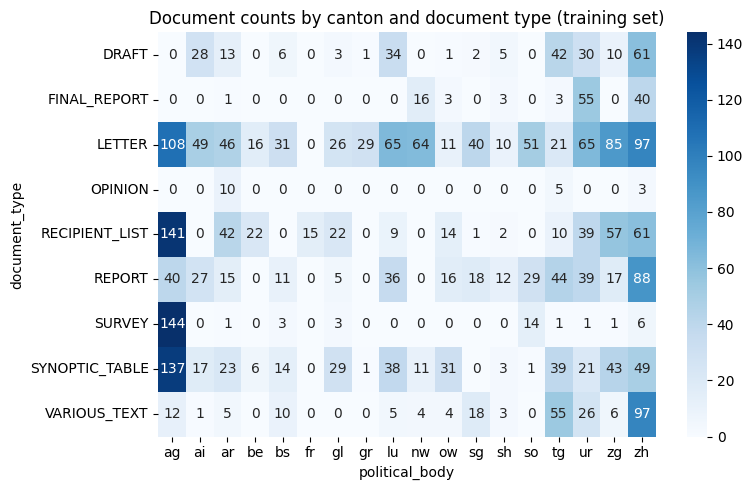

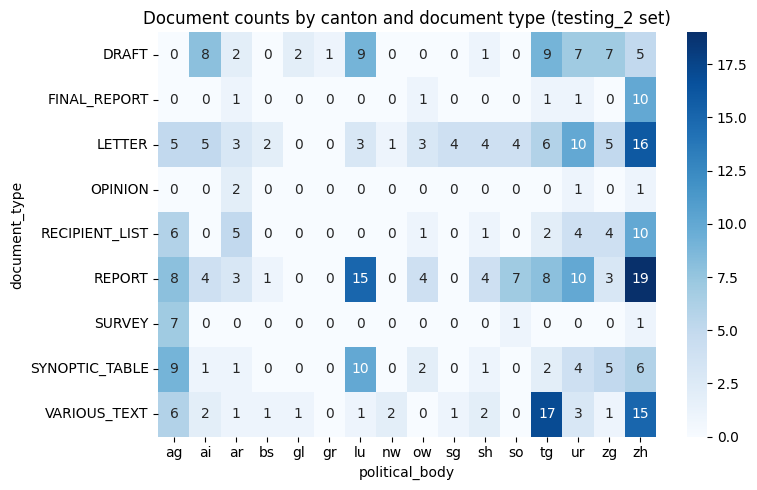

In [15]:
def plot_documents_per_canton(df: pd.DataFrame, set_name: str) -> None:
    df = df[df["political_body"] != "ch"]
    count_matrix = pd.crosstab(df["document_type"], df["political_body"])
    count_matrix = count_matrix.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(count_matrix, annot=True, fmt="g", cmap="Blues")
    plt.title(f"Document counts by canton and document type ({set_name} set)")
    plt.tight_layout()
    plt.show()


plot_documents_per_canton(df_input_train, "training")
plot_documents_per_canton(df_input_test_2, "testing_2")

In [16]:
display(df_input_train["document_type_label_source"].value_counts(dropna=False))
display(df_input_train["document_type"].value_counts(dropna=False))

document_type_label_source
fedlex    12232
manual     1685
rule       1219
Name: count, dtype: int64

document_type
LETTER            3264
DRAFT             3057
REPORT            2492
RECIPIENT_LIST    2162
FINAL_REPORT      1839
OPINION            895
VARIOUS_TEXT       651
SYNOPTIC_TABLE     579
SURVEY             197
DECISION             0
LINK                 0
PRESS_RELEASE        0
RESPONSE_FORM        0
Name: count, dtype: int64

In [17]:
display(df_input_test_2["document_type_label_source"].value_counts(dropna=False))
display(df_input_test_2["document_type"].value_counts(dropna=False))

document_type_label_source
manual    362
rule        0
fedlex      0
Name: count, dtype: int64

document_type
REPORT            86
LETTER            71
VARIOUS_TEXT      53
DRAFT             51
SYNOPTIC_TABLE    41
RECIPIENT_LIST    33
FINAL_REPORT      14
SURVEY             9
OPINION            4
DECISION           0
LINK               0
PRESS_RELEASE      0
RESPONSE_FORM      0
Name: count, dtype: int64

In [18]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_1_samples_count", len(df_input_test_1))
mlflow.log_param("test_2_samples_count", len(df_input_test_2))

362

# Data exploration

## Data representation

In [19]:
print("df_input_train labels:")
df_input_train.groupby("document_type_label_source", observed=False)["document_type"].value_counts(dropna=False)

df_input_train labels:


document_type_label_source  document_type 
rule                        LETTER             485
                            RECIPIENT_LIST     278
                            SYNOPTIC_TABLE     271
                            SURVEY             129
                            FINAL_REPORT        56
                            DECISION             0
                            DRAFT                0
                            LINK                 0
                            OPINION              0
                            PRESS_RELEASE        0
                            REPORT               0
                            RESPONSE_FORM        0
                            VARIOUS_TEXT         0
manual                      REPORT             397
                            LETTER             329
                            VARIOUS_TEXT       246
                            DRAFT              236
                            SYNOPTIC_TABLE     192
                            RECIPIENT_L

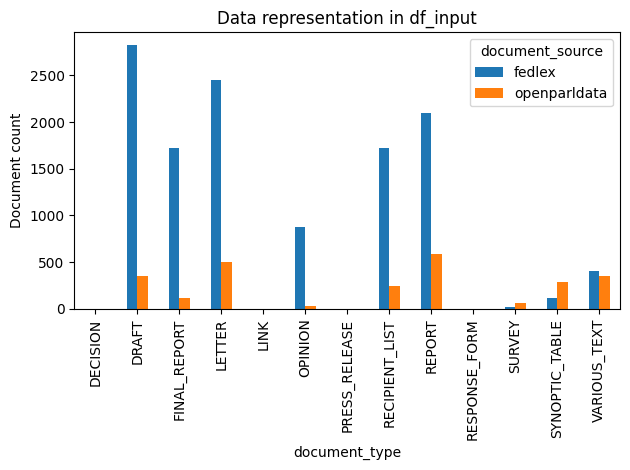

document_source,fedlex,openparldata
document_type,,
DECISION,0,0
DRAFT,2821,356
FINAL_REPORT,1718,112
LETTER,2450,497
LINK,0,0
OPINION,877,27
PRESS_RELEASE,0,0
RECIPIENT_LIST,1727,241
REPORT,2095,589


In [20]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
    )
)
display(repr_table)

## Extra features

In [21]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
DRAFT,0.001063,0.000000
FINAL_REPORT,0.002910,0.035714
LETTER,0.985306,0.995976
OPINION,0.751425,0.666667
RECIPIENT_LIST,0.000000,0.000000
REPORT,0.013365,0.049236
SURVEY,0.000000,0.046154
SYNOPTIC_TABLE,0.000000,0.000000
VARIOUS_TEXT,0.014815,0.014205


### Keyword-like features

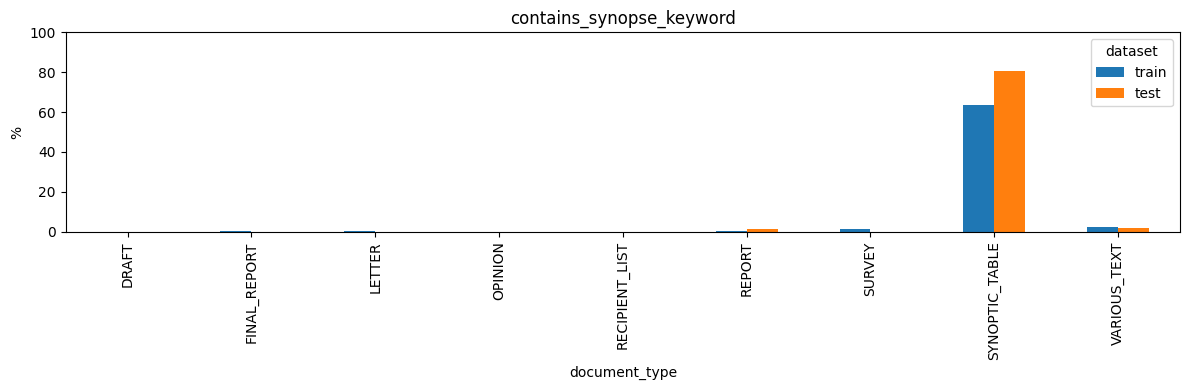

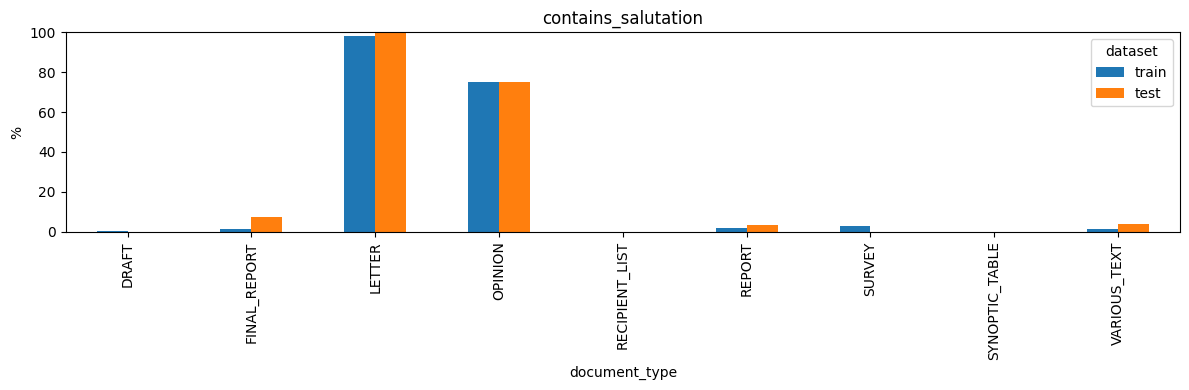

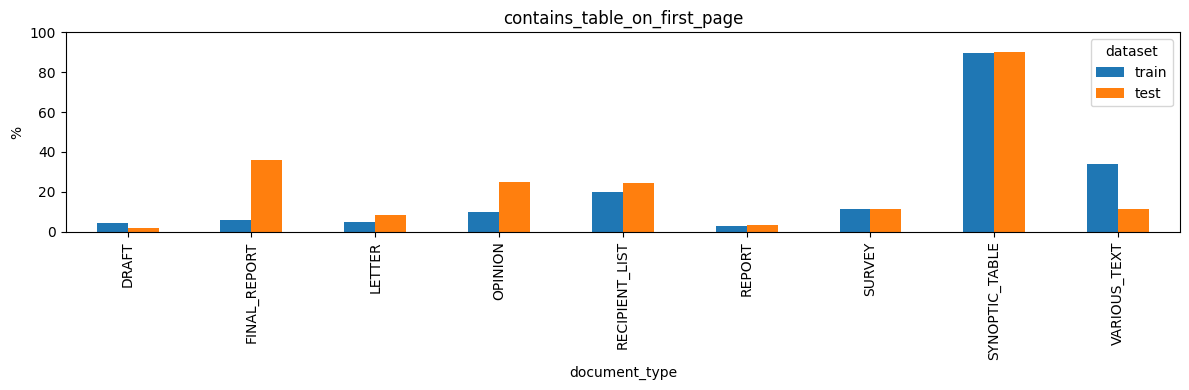

In [22]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_salutation")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_table_on_first_page")

In [23]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
    )
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

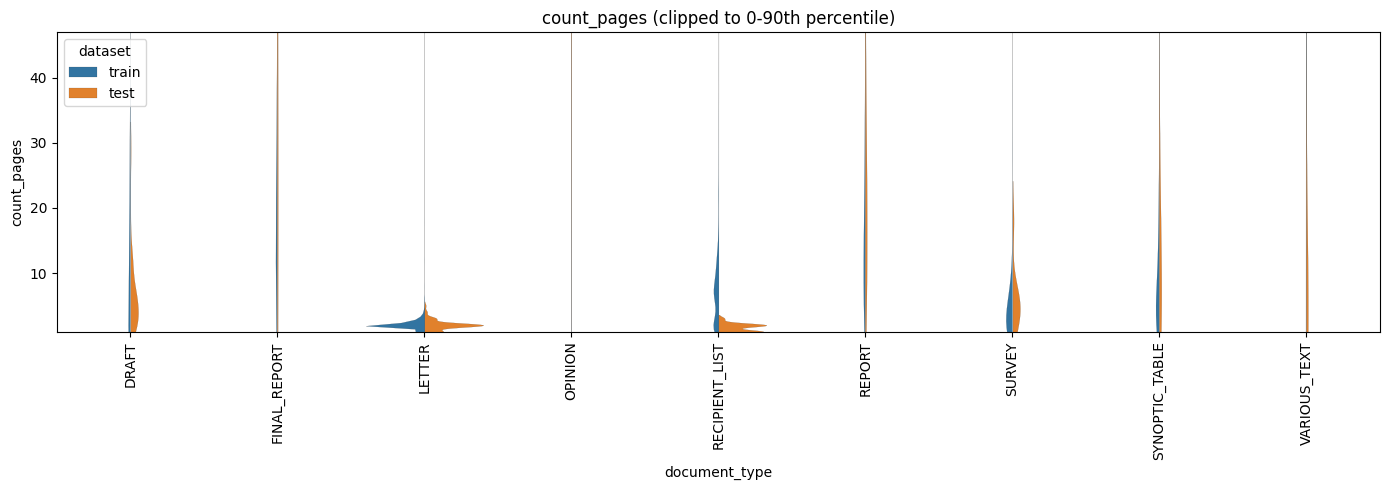

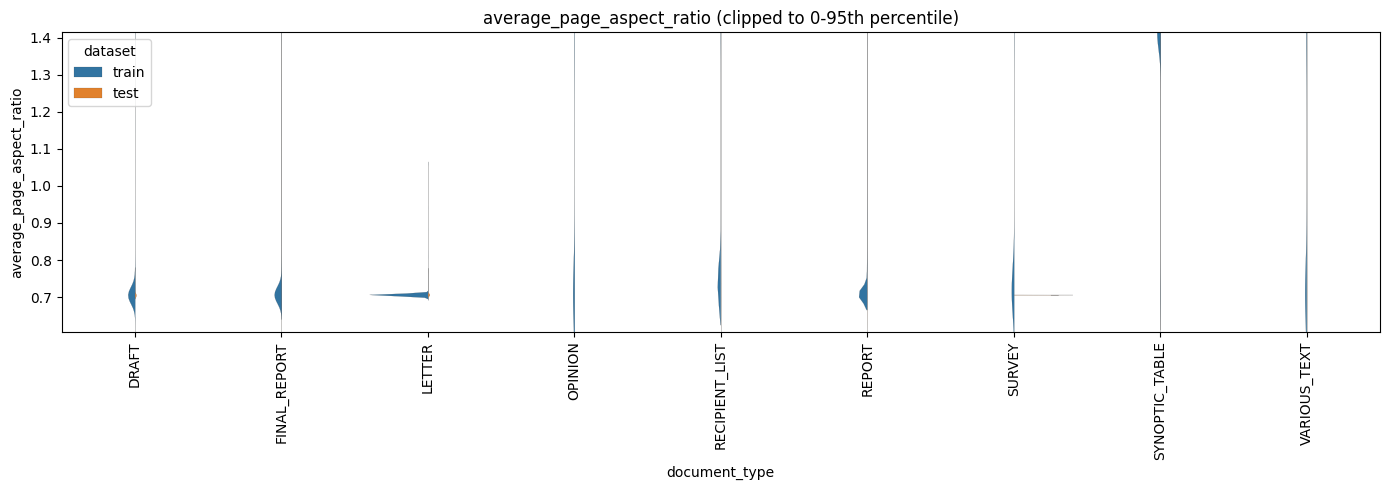

In [24]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "average_page_aspect_ratio", clip_y=(0, 95)
)

In [25]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                    std            
dataset               test       train       test       train
document_type                                                
DRAFT             5.980392   13.871770   4.709523   45.537108
FINAL_REPORT     37.071429   27.007069  42.535893   43.950975
LETTER            2.028169    2.148591   0.755396    1.389834
OPINION         103.750000  358.615642  40.541131  701.102602
RECIPIENT_LIST    1.606061    7.163737   0.609272    5.416397
REPORT           24.348837   24.793339  22.233926   30.462134
SURVEY            6.000000    4.700508   4.795832    7.437951
SYNOPTIC_TABLE   14.292683   10.880829  18.316992   14.268118
VARIOUS_TEXT     12.773585   21.248848  28.888141  154.521493

In [26]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.707103  0.729058  0.009436  0.112101
FINAL_REPORT    0.973698  0.725695  0.309518  0.099439
LETTER          0.707943  0.707762  0.007838  0.014206
OPINION         0.000000  0.818134  0.000000  0.244001
RECIPIENT_LIST  0.728485  0.769434  0.123293  0.178644
REPORT          0.750574  0.722813  0.141966  0.084762
SURVEY          0.707030  0.765981  0.000082  0.171653
SYNOPTIC_TABLE  1.332757  1.371071  0.208022  0.163570
VARIOUS_TEXT    0.752654  0.879580  0.158816  0.303608

### Tables

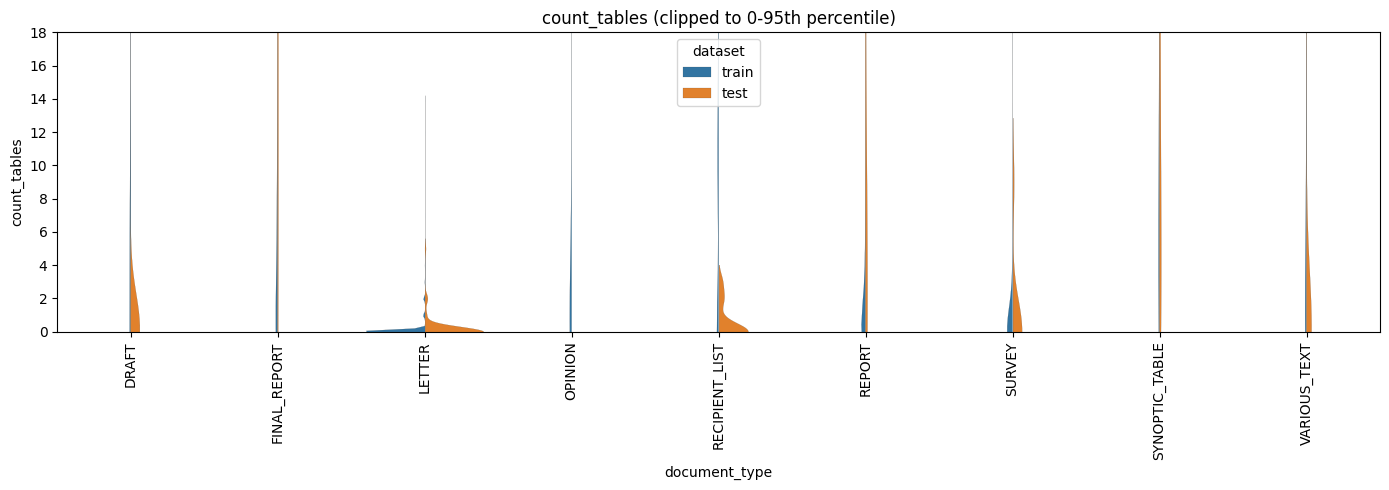

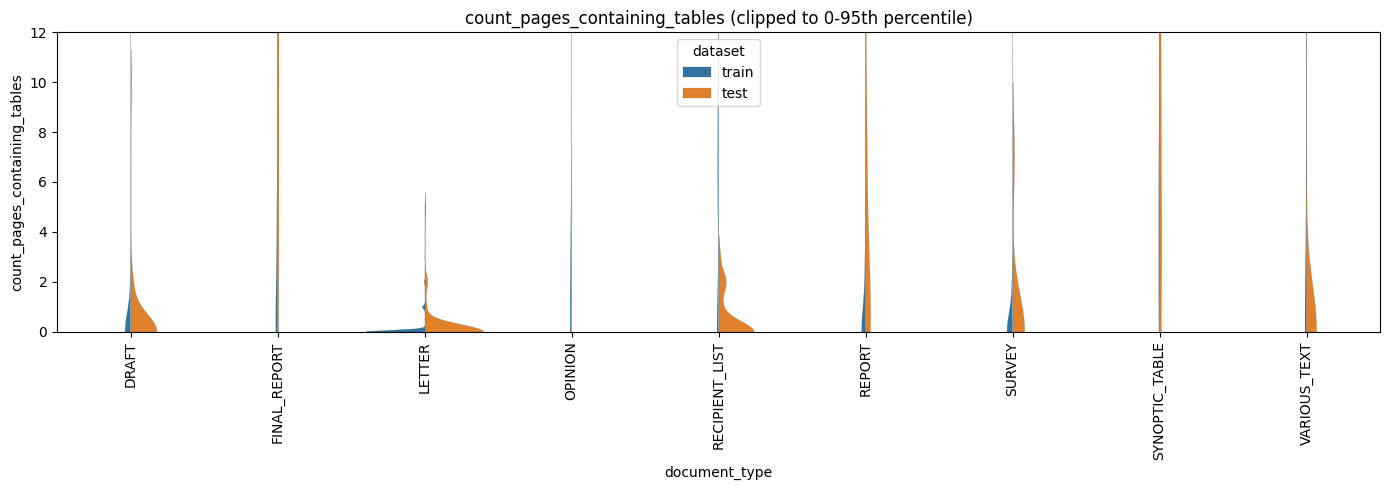

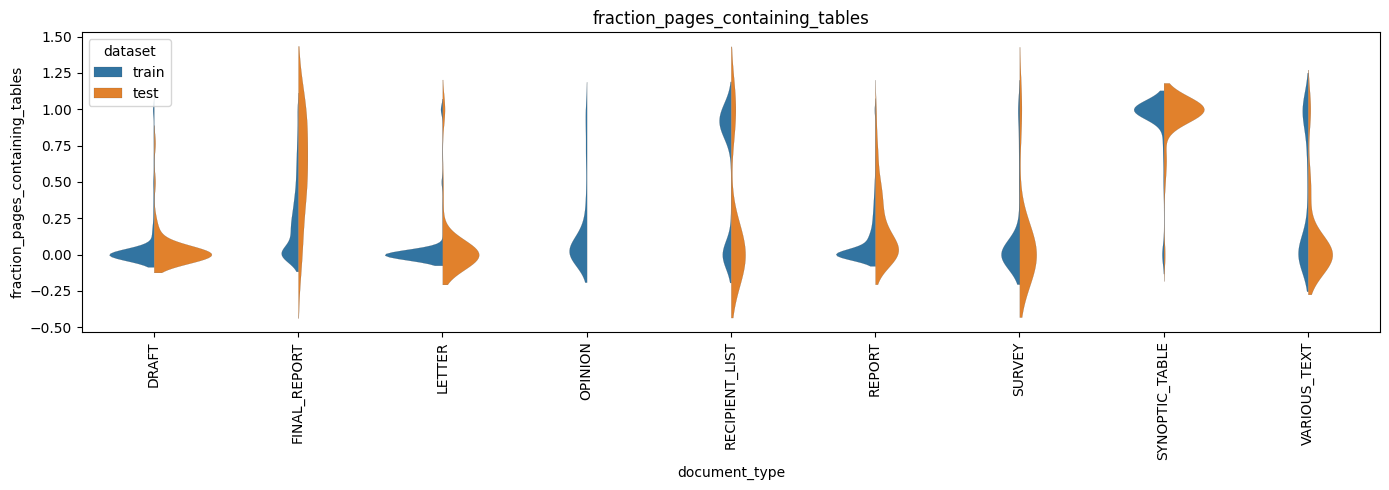

In [27]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_tables")

### Images

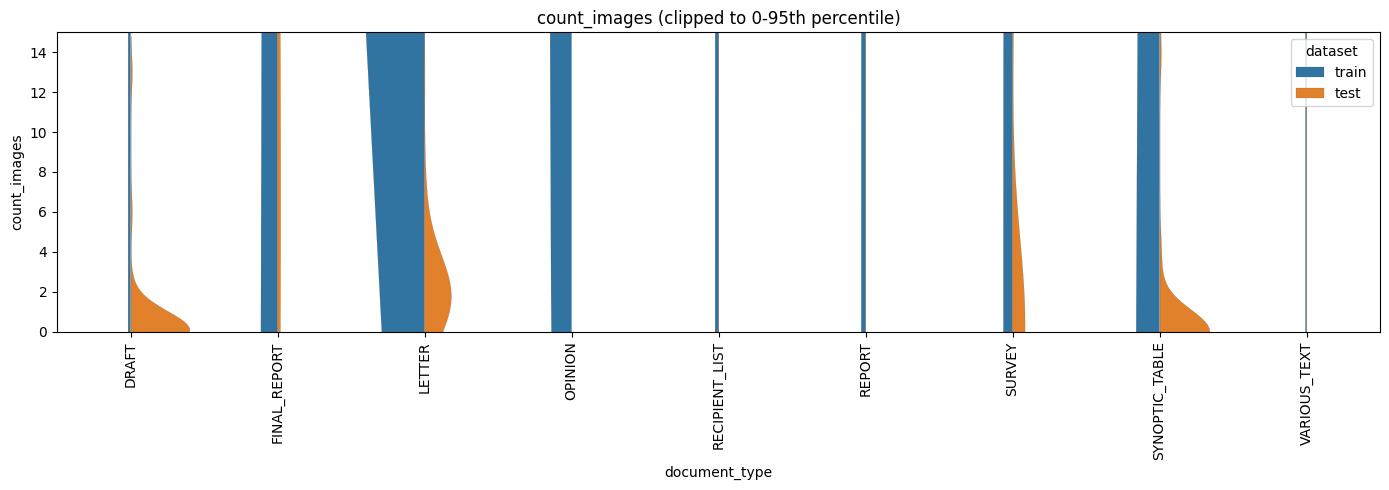

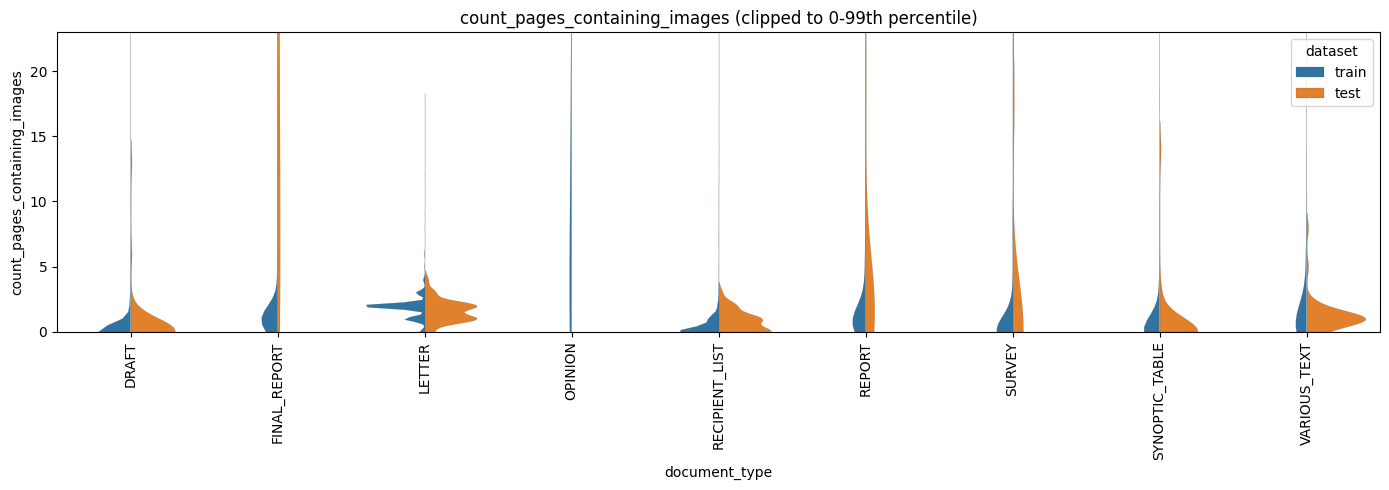

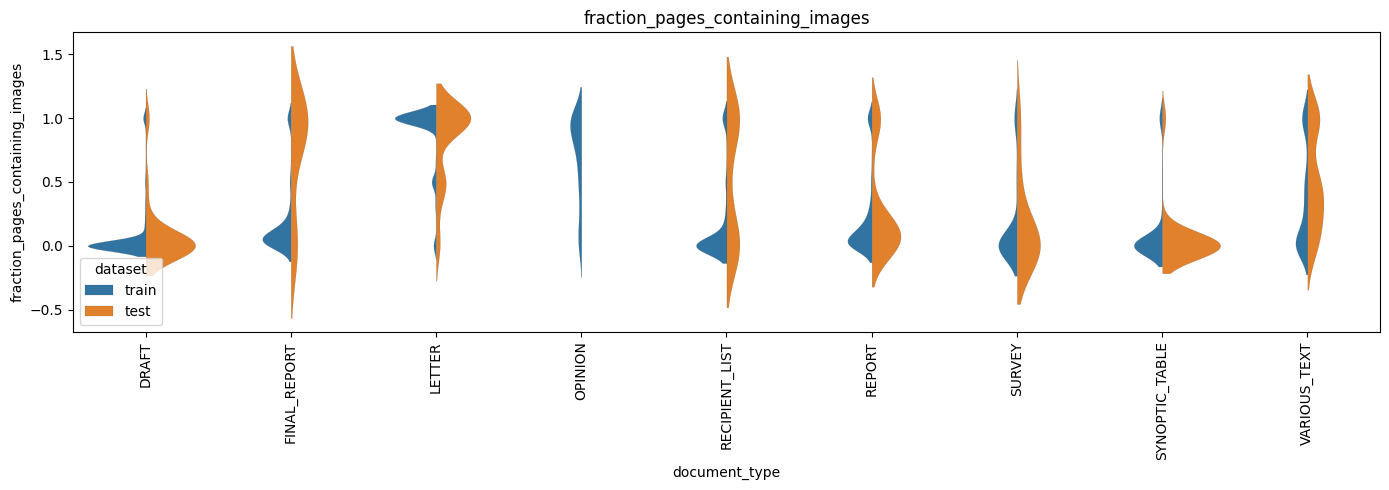

In [28]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_images")

### Time features

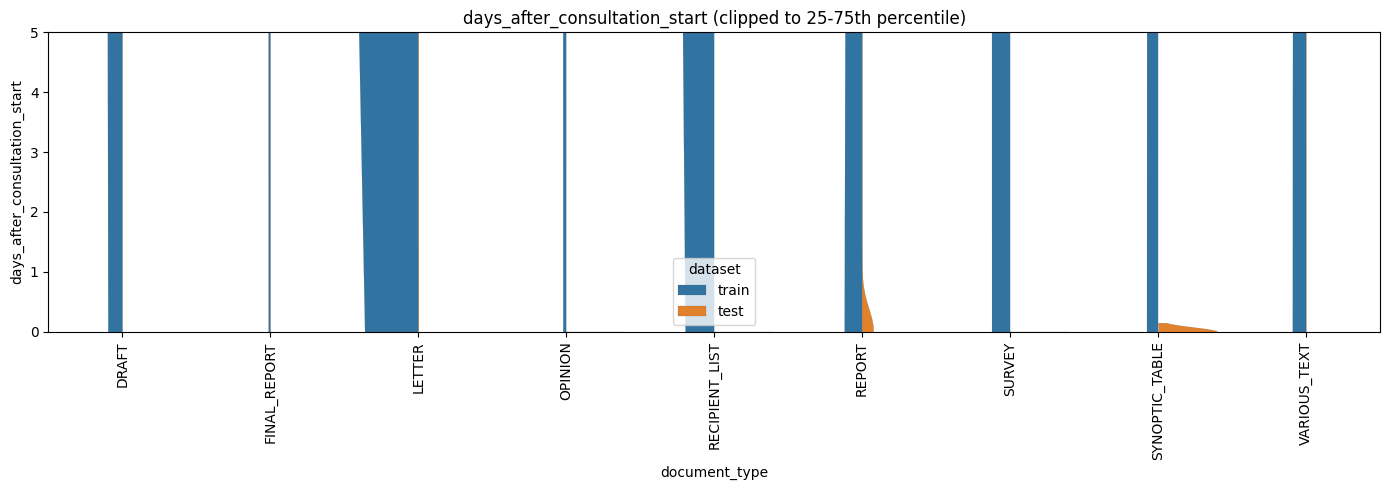

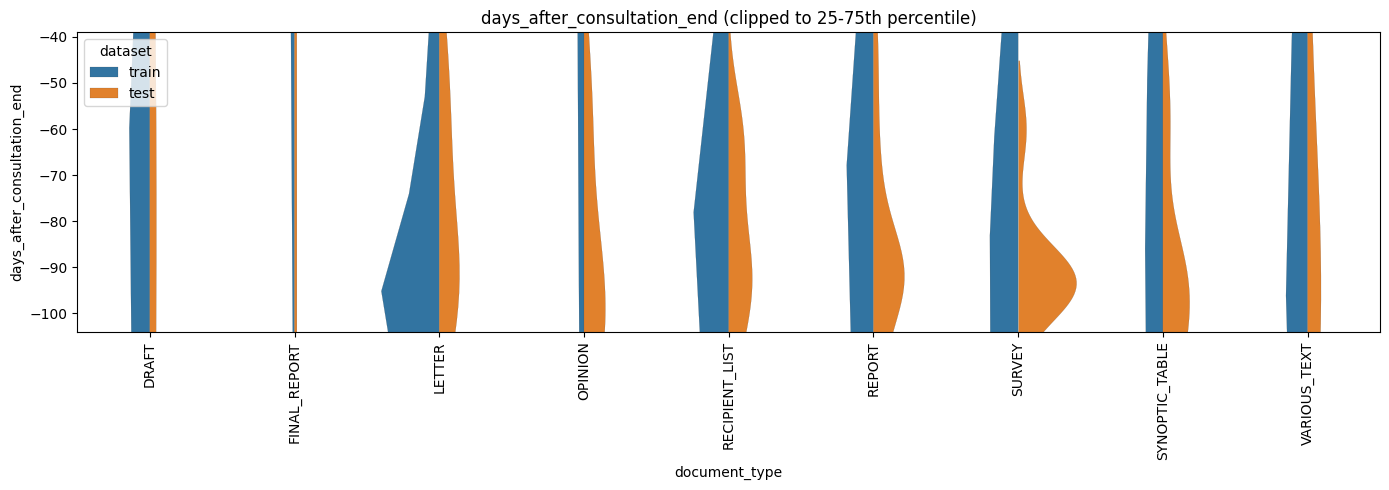

In [29]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_start",
    clip_y=(25, 75),
)
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_end",
    clip_y=(25, 75),
)

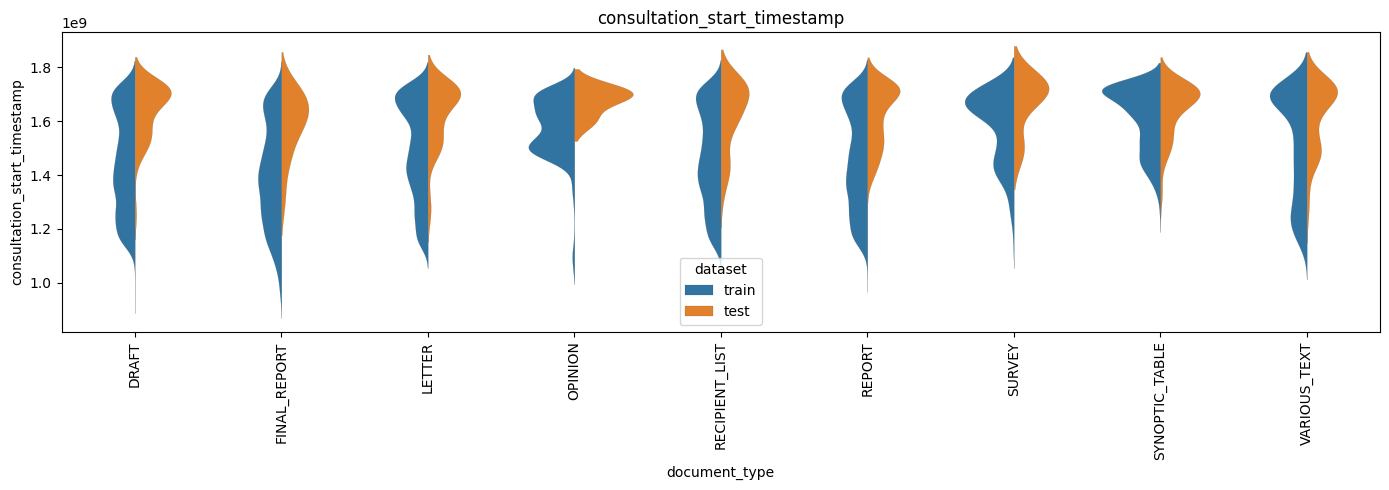

In [30]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "consultation_start_timestamp",
    # clip_y=(25, 75),
)

# Classification

In [31]:
mlflow.log_param("extra_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS))
mlflow.log_param(
    "extra_categorical_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
)

X_train, y_train = demokratis_ml.models.document_types.model.create_matrices(df_input_train, fill_nulls=True)
X_test_1, y_test_1 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_1, fill_nulls=True)
X_test_2, y_test_2 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_2, fill_nulls=True)

print("train", X_train.shape)
print("test_1", X_test_1.shape)
print("test_2", X_test_2.shape)

train (15136, 3084)
test_1 (361, 3084)
test_2 (362, 3084)


## Hyperoptimisation on test_1

In [33]:
from hyperopt import pyll


def objective_function(params: dict[str, Any]) -> dict[str, Any]:
    logging.info("Training for hyperparameters: %s", params)
    # return {"loss": 1, "status": hyperopt.STATUS_OK}
    classifier = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        random_state=RANDOM_STATE,
        params=params,
    )
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test_1)
    f1 = sklearn.metrics.f1_score(y_test_1, y_pred, average="weighted", zero_division=np.nan)
    logging.info("F1=%.3f for %s", f1, params)
    return {"loss": -f1, "status": hyperopt.STATUS_OK, "params": params, "f1": f1}


max_evals = 200

# See https://github.com/hyperopt/hyperopt/issues/253 about the scope.int call
quniform = lambda name, low, high, q: pyll.base.scope.int(hyperopt.hp.quniform(name, low, high, q))  # noqa: E731

search_space = {
    "pca_n_components": quniform("pca_n_components", 10, 300, 10),
    "classifier": hyperopt.hp.choice(
        "classifier",
        [
            {
                "type": "LogisticRegression",
            },
            {
                "type": "SVC",
                "C": hyperopt.hp.lognormal("svm_C", 0, 1),
                "kernel": hyperopt.hp.choice(
                    "svm_kernel",
                    [
                        {"type": "poly"},
                        {"type": "rbf"},
                        {"type": "sigmoid"},
                    ],
                ),
                "class_weight": hyperopt.hp.choice("svm_class_weight", ["balanced", None]),
            },
            {
                "type": "MLP",
                "hidden_layer_sizes": hyperopt.hp.choice(
                    "hidden_layer_sizes",
                    [
                        (quniform("hidden_layer_size", 64, 512, 32),),
                        (
                            quniform("hidden_layer_size_0", 64, 512, 32),
                            quniform("hidden_layer_size_1", 64, 512, 32),
                        ),
                    ],
                ),
            },
            {
                "type": "RandomForest",
                "n_estimators": quniform("rf_n_estimators", 10, 200, 10),
                "criterion": hyperopt.hp.choice("rf_criterion", ["gini", "entropy", "log_loss"]),
                "max_depth": hyperopt.hp.choice("rf_max_depth_choice", [None, quniform("rf_max_depth", 5, 50, 1)]),
                "min_samples_split": quniform("rf_min_samples_split", 2, 20, 1),
                "min_samples_leaf": quniform("rf_min_samples_leaf", 1, 20, 1),
                "class_weight": hyperopt.hp.choice("rf_class_weight", ["balanced", None]),
            },
        ],
    ),
}

trials = hyperopt.Trials()

best_params = hyperopt.fmin(
    objective_function,
    search_space,
    algo=hyperopt.tpe.suggest,
    max_evals=max_evals,
    trials=trials,
)
best_params


  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002889 seconds
INFO hyperopt.tpe: TPE using 0 trials


INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 80}
INFO root: F1=0.888 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 80}


  0%|          | 1/200 [00:10<35:52, 10.82s/trial, best loss: -0.8883685458478228]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006453 seconds
INFO hyperopt.tpe: TPE using 1/1 trials with best loss -0.888369
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (160, 448), 'type': 'MLP'}, 'pca_n_components': 50}
INFO root: F1=0.917 for {'classifier': {'hidden_layer_sizes': (160, 448), 'type': 'MLP'}, 'pca_n_components': 50}


  1%|          | 2/200 [00:28<48:36, 14.73s/trial, best loss: -0.9168795479575735]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002163 seconds
INFO hyperopt.tpe: TPE using 2/2 trials with best loss -0.916880
INFO root: Training for hyperparameters: {'classifier': {'C': 0.3271942924109413, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 260}
INFO root: F1=0.922 for {'classifier': {'C': 0.3271942924109413, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 260}


  2%|▏         | 3/200 [00:36<38:17, 11.66s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002397 seconds
INFO hyperopt.tpe: TPE using 3/3 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 200, 'type': 'RandomForest'}, 'pca_n_components': 220}
INFO root: F1=0.877 for {'classifier': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 200, 'type': 'RandomForest'}, 'pca_n_components': 220}


  2%|▏         | 4/200 [01:22<1:23:06, 25.44s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006319 seconds
INFO hyperopt.tpe: TPE using 4/4 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'C': 0.17989603818444277, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 70}
INFO root: F1=0.815 for {'classifier': {'C': 0.17989603818444277, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 70}


  2%|▎         | 5/200 [01:27<57:59, 17.84s/trial, best loss: -0.9216861678324935]  

INFO hyperopt.tpe: build_posterior_wrapper took 0.002063 seconds
INFO hyperopt.tpe: TPE using 5/5 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'C': 5.4278815161652405, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 30}
INFO root: F1=0.889 for {'classifier': {'C': 5.4278815161652405, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 30}


  3%|▎         | 6/200 [01:30<41:56, 12.97s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.028739 seconds
INFO hyperopt.tpe: TPE using 6/6 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 190}
INFO root: F1=0.880 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 190}


  4%|▎         | 7/200 [01:41<39:33, 12.30s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002550 seconds
INFO hyperopt.tpe: TPE using 7/7 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'C': 0.16830358808420864, 'class_weight': 'balanced', 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 280}
INFO root: F1=0.822 for {'classifier': {'C': 0.16830358808420864, 'class_weight': 'balanced', 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 280}


  4%|▍         | 8/200 [01:53<38:30, 12.03s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002361 seconds
INFO hyperopt.tpe: TPE using 8/8 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 180}
INFO root: F1=0.860 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 180}


  4%|▍         | 9/200 [02:03<37:02, 11.63s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002273 seconds
INFO hyperopt.tpe: TPE using 9/9 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'C': 0.6205298598045681, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 70}
INFO root: F1=0.913 for {'classifier': {'C': 0.6205298598045681, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 70}


  5%|▌         | 10/200 [02:08<29:43,  9.39s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.005418 seconds
INFO hyperopt.tpe: TPE using 10/10 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 110, 'type': 'RandomForest'}, 'pca_n_components': 60}
INFO root: F1=0.863 for {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 110, 'type': 'RandomForest'}, 'pca_n_components': 60}


  6%|▌         | 11/200 [02:19<31:41, 10.06s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007321 seconds
INFO hyperopt.tpe: TPE using 11/11 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 20}
INFO root: F1=0.834 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 20}


  6%|▌         | 12/200 [02:28<30:33,  9.75s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007797 seconds
INFO hyperopt.tpe: TPE using 12/12 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 270}
INFO root: F1=0.871 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 270}


  6%|▋         | 13/200 [02:47<38:40, 12.41s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.005463 seconds
INFO hyperopt.tpe: TPE using 13/13 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'C': 0.5594143404978288, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 10}
INFO root: F1=0.840 for {'classifier': {'C': 0.5594143404978288, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 10}


  7%|▋         | 14/200 [02:50<29:46,  9.61s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002357 seconds
INFO hyperopt.tpe: TPE using 14/14 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'C': 0.29000033651567886, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 160}
INFO root: F1=0.907 for {'classifier': {'C': 0.29000033651567886, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 160}


  8%|▊         | 15/200 [02:55<25:45,  8.35s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002360 seconds
INFO hyperopt.tpe: TPE using 15/15 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'C': 0.6271962851976337, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.911 for {'classifier': {'C': 0.6271962851976337, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 200}


  8%|▊         | 16/200 [03:07<28:45,  9.38s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002099 seconds
INFO hyperopt.tpe: TPE using 16/16 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 15, 'min_samples_split': 18, 'n_estimators': 20, 'type': 'RandomForest'}, 'pca_n_components': 120}
INFO root: F1=0.825 for {'classifier': {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 15, 'min_samples_split': 18, 'n_estimators': 20, 'type': 'RandomForest'}, 'pca_n_components': 120}


  8%|▊         | 17/200 [03:13<24:58,  8.19s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006844 seconds
INFO hyperopt.tpe: TPE using 17/17 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 130}
INFO root: F1=0.879 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 130}


  9%|▉         | 18/200 [03:26<29:44,  9.81s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002817 seconds
INFO hyperopt.tpe: TPE using 18/18 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (64,), 'type': 'MLP'}, 'pca_n_components': 220}
INFO root: F1=0.895 for {'classifier': {'hidden_layer_sizes': (64,), 'type': 'MLP'}, 'pca_n_components': 220}


 10%|▉         | 19/200 [03:36<29:07,  9.66s/trial, best loss: -0.9216861678324935]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002374 seconds
INFO hyperopt.tpe: TPE using 19/19 trials with best loss -0.921686
INFO root: Training for hyperparameters: {'classifier': {'C': 2.9363616023062495, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 210}
INFO root: F1=0.927 for {'classifier': {'C': 2.9363616023062495, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 210}


 10%|█         | 20/200 [03:48<31:27, 10.48s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002144 seconds
INFO hyperopt.tpe: TPE using 20/20 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'C': 2.622821828806904, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 260}
INFO root: F1=0.899 for {'classifier': {'C': 2.622821828806904, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 260}


 10%|█         | 21/200 [03:55<27:55,  9.36s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002389 seconds
INFO hyperopt.tpe: TPE using 21/21 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (512, 96), 'type': 'MLP'}, 'pca_n_components': 240}
INFO root: F1=0.916 for {'classifier': {'hidden_layer_sizes': (512, 96), 'type': 'MLP'}, 'pca_n_components': 240}


 11%|█         | 22/200 [04:17<39:34, 13.34s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.004213 seconds
INFO hyperopt.tpe: TPE using 22/22 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'C': 1.8652373163994402, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 300}
INFO root: F1=0.925 for {'classifier': {'C': 1.8652373163994402, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 300}


 12%|█▏        | 23/200 [04:37<44:57, 15.24s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002212 seconds
INFO hyperopt.tpe: TPE using 23/23 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'C': 2.3605345548393863, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 300}
INFO root: F1=0.919 for {'classifier': {'C': 2.3605345548393863, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 300}


 12%|█▏        | 24/200 [04:57<48:56, 16.69s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002364 seconds
INFO hyperopt.tpe: TPE using 24/24 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'C': 2.2012689589182455, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 290}
INFO root: F1=0.925 for {'classifier': {'C': 2.2012689589182455, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 290}


 12%|█▎        | 25/200 [05:15<49:34, 17.00s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002108 seconds
INFO hyperopt.tpe: TPE using 25/25 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (512,), 'type': 'MLP'}, 'pca_n_components': 110}
INFO root: F1=0.902 for {'classifier': {'hidden_layer_sizes': (512,), 'type': 'MLP'}, 'pca_n_components': 110}


 13%|█▎        | 26/200 [05:25<43:25, 14.97s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002213 seconds
INFO hyperopt.tpe: TPE using 26/26 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 29, 'min_samples_leaf': 18, 'min_samples_split': 3, 'n_estimators': 10, 'type': 'RandomForest'}, 'pca_n_components': 160}
INFO root: F1=0.806 for {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 29, 'min_samples_leaf': 18, 'min_samples_split': 3, 'n_estimators': 10, 'type': 'RandomForest'}, 'pca_n_components': 160}


 14%|█▎        | 27/200 [05:29<34:03, 11.81s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007296 seconds
INFO hyperopt.tpe: TPE using 27/27 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'C': 3.108293697922215, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 240}
INFO root: F1=0.925 for {'classifier': {'C': 3.108293697922215, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 240}


 14%|█▍        | 28/200 [05:44<35:54, 12.53s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002212 seconds
INFO hyperopt.tpe: TPE using 28/28 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'C': 1.4771512950958638, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 140}
INFO root: F1=0.927 for {'classifier': {'C': 1.4771512950958638, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 140}


 14%|█▍        | 29/200 [05:51<31:35, 11.09s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007222 seconds
INFO hyperopt.tpe: TPE using 29/29 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'C': 1.3956127058430166, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 100}
INFO root: F1=0.913 for {'classifier': {'C': 1.3956127058430166, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 100}


 15%|█▌        | 30/200 [05:56<26:18,  9.29s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.012004 seconds
INFO hyperopt.tpe: TPE using 30/30 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (480, 96), 'type': 'MLP'}, 'pca_n_components': 140}
INFO root: F1=0.919 for {'classifier': {'hidden_layer_sizes': (480, 96), 'type': 'MLP'}, 'pca_n_components': 140}


 16%|█▌        | 31/200 [06:08<27:50,  9.88s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.004751 seconds
INFO hyperopt.tpe: TPE using 31/31 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'C': 3.8616053945906867, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 90}
INFO root: F1=0.914 for {'classifier': {'C': 3.8616053945906867, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 90}


 16%|█▌        | 32/200 [06:12<23:04,  8.24s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002140 seconds
INFO hyperopt.tpe: TPE using 32/32 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'log_loss', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 13, 'n_estimators': 190, 'type': 'RandomForest'}, 'pca_n_components': 170}
INFO root: F1=0.699 for {'classifier': {'class_weight': None, 'criterion': 'log_loss', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 13, 'n_estimators': 190, 'type': 'RandomForest'}, 'pca_n_components': 170}


 16%|█▋        | 33/200 [06:40<38:59, 14.01s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.009689 seconds
INFO hyperopt.tpe: TPE using 33/33 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'C': 1.060481611574177, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 210}
INFO root: F1=0.921 for {'classifier': {'C': 1.060481611574177, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 210}


 17%|█▋        | 34/200 [06:52<37:04, 13.40s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002118 seconds
INFO hyperopt.tpe: TPE using 34/34 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (288,), 'type': 'MLP'}, 'pca_n_components': 40}
INFO root: F1=0.882 for {'classifier': {'hidden_layer_sizes': (288,), 'type': 'MLP'}, 'pca_n_components': 40}


 18%|█▊        | 35/200 [07:03<35:08, 12.78s/trial, best loss: -0.9274274099278603]

INFO hyperopt.tpe: build_posterior_wrapper took 0.003237 seconds
INFO hyperopt.tpe: TPE using 35/35 trials with best loss -0.927427
INFO root: Training for hyperparameters: {'classifier': {'C': 17.994498942978826, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 140}
INFO root: F1=0.928 for {'classifier': {'C': 17.994498942978826, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 140}


 18%|█▊        | 36/200 [07:10<30:11, 11.05s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.009969 seconds
INFO hyperopt.tpe: TPE using 36/36 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 49, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 90, 'type': 'RandomForest'}, 'pca_n_components': 240}
INFO root: F1=0.863 for {'classifier': {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 49, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 90, 'type': 'RandomForest'}, 'pca_n_components': 240}


 18%|█▊        | 37/200 [07:29<36:12, 13.33s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007174 seconds
INFO hyperopt.tpe: TPE using 37/37 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'C': 71.82002285001647, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 190}
INFO root: F1=0.928 for {'classifier': {'C': 71.82002285001647, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 190}


 19%|█▉        | 38/200 [07:38<32:54, 12.19s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002174 seconds
INFO hyperopt.tpe: TPE using 38/38 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 180}
INFO root: F1=0.860 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 180}


 20%|█▉        | 39/200 [07:47<30:10, 11.25s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006410 seconds
INFO hyperopt.tpe: TPE using 39/39 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'C': 324.55531246739804, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 150}
INFO root: F1=0.923 for {'classifier': {'C': 324.55531246739804, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 150}


 20%|██        | 40/200 [07:52<25:01,  9.39s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007011 seconds
INFO hyperopt.tpe: TPE using 40/40 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'C': 46.95657277402987, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 90}
INFO root: F1=0.908 for {'classifier': {'C': 46.95657277402987, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 90}


 20%|██        | 41/200 [07:57<21:03,  7.95s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.008889 seconds
INFO hyperopt.tpe: TPE using 41/41 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 190}
INFO root: F1=0.880 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 190}


 21%|██        | 42/200 [08:07<22:46,  8.65s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002138 seconds
INFO hyperopt.tpe: TPE using 42/42 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 19, 'min_samples_split': 15, 'n_estimators': 130, 'type': 'RandomForest'}, 'pca_n_components': 120}
INFO root: F1=0.802 for {'classifier': {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 19, 'min_samples_split': 15, 'n_estimators': 130, 'type': 'RandomForest'}, 'pca_n_components': 120}


 22%|██▏       | 43/200 [08:27<31:42, 12.12s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002875 seconds
INFO hyperopt.tpe: TPE using 43/43 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'C': 27.727195274851915, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 70}
INFO root: F1=0.903 for {'classifier': {'C': 27.727195274851915, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 70}


 22%|██▏       | 44/200 [08:31<24:57,  9.60s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.005493 seconds
INFO hyperopt.tpe: TPE using 44/44 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (96,), 'type': 'MLP'}, 'pca_n_components': 180}
INFO root: F1=0.912 for {'classifier': {'hidden_layer_sizes': (96,), 'type': 'MLP'}, 'pca_n_components': 180}


 22%|██▎       | 45/200 [08:42<25:39,  9.93s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.009014 seconds
INFO hyperopt.tpe: TPE using 45/45 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'C': 57.805241301855304, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 50}
INFO root: F1=0.912 for {'classifier': {'C': 57.805241301855304, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 50}


 23%|██▎       | 46/200 [08:46<21:01,  8.19s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002589 seconds
INFO hyperopt.tpe: TPE using 46/46 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 220}
INFO root: F1=0.881 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 220}


 24%|██▎       | 47/200 [08:59<24:28,  9.60s/trial, best loss: -0.9278497958482497]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006548 seconds
INFO hyperopt.tpe: TPE using 47/47 trials with best loss -0.927850
INFO root: Training for hyperparameters: {'classifier': {'C': 13.910360558568062, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 170}
INFO root: F1=0.929 for {'classifier': {'C': 13.910360558568062, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 170}


 24%|██▍       | 48/200 [09:05<22:09,  8.75s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002369 seconds
INFO hyperopt.tpe: TPE using 48/48 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 60, 'type': 'RandomForest'}, 'pca_n_components': 150}
INFO root: F1=0.815 for {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 60, 'type': 'RandomForest'}, 'pca_n_components': 150}


 24%|██▍       | 49/200 [09:14<21:45,  8.65s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007236 seconds
INFO hyperopt.tpe: TPE using 49/49 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'C': 16.334576029087074, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 110}
INFO root: F1=0.926 for {'classifier': {'C': 16.334576029087074, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 110}


 25%|██▌       | 50/200 [09:19<18:47,  7.52s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002144 seconds
INFO hyperopt.tpe: TPE using 50/50 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 90}
INFO root: F1=0.875 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 90}


 26%|██▌       | 51/200 [09:33<23:27,  9.45s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002415 seconds
INFO hyperopt.tpe: TPE using 51/51 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'C': 15.81658492180847, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 130}
INFO root: F1=0.929 for {'classifier': {'C': 15.81658492180847, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 130}


 26%|██▌       | 52/200 [09:38<20:27,  8.29s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002208 seconds
INFO hyperopt.tpe: TPE using 52/52 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (64, 512), 'type': 'MLP'}, 'pca_n_components': 170}
INFO root: F1=0.883 for {'classifier': {'hidden_layer_sizes': (64, 512), 'type': 'MLP'}, 'pca_n_components': 170}


 26%|██▋       | 53/200 [09:53<25:09, 10.27s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002519 seconds
INFO hyperopt.tpe: TPE using 53/53 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'C': 14.826073464430808, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 20}
INFO root: F1=0.900 for {'classifier': {'C': 14.826073464430808, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 20}


 27%|██▋       | 54/200 [09:56<19:41,  8.09s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002151 seconds
INFO hyperopt.tpe: TPE using 54/54 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'C': 11.819443323945135, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}
INFO root: F1=0.923 for {'classifier': {'C': 11.819443323945135, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}


 28%|██▊       | 55/200 [10:05<20:17,  8.40s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002159 seconds
INFO hyperopt.tpe: TPE using 55/55 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 13, 'min_samples_split': 3, 'n_estimators': 150, 'type': 'RandomForest'}, 'pca_n_components': 60}
INFO root: F1=0.851 for {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 13, 'min_samples_split': 3, 'n_estimators': 150, 'type': 'RandomForest'}, 'pca_n_components': 60}


 28%|██▊       | 56/200 [10:17<22:40,  9.45s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.003786 seconds
INFO hyperopt.tpe: TPE using 56/56 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 270}
INFO root: F1=0.871 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 270}


 28%|██▊       | 57/200 [10:30<24:56, 10.47s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002849 seconds
INFO hyperopt.tpe: TPE using 57/57 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'C': 11.879782960673696, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 130}
INFO root: F1=0.926 for {'classifier': {'C': 11.879782960673696, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 130}


 29%|██▉       | 58/200 [10:36<21:21,  9.02s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002096 seconds
INFO hyperopt.tpe: TPE using 58/58 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (512,), 'type': 'MLP'}, 'pca_n_components': 80}
INFO root: F1=0.907 for {'classifier': {'hidden_layer_sizes': (512,), 'type': 'MLP'}, 'pca_n_components': 80}


 30%|██▉       | 59/200 [10:50<24:52, 10.58s/trial, best loss: -0.9286479425520227]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006627 seconds
INFO hyperopt.tpe: TPE using 59/59 trials with best loss -0.928648
INFO root: Training for hyperparameters: {'classifier': {'C': 20.79454711372255, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.934 for {'classifier': {'C': 20.79454711372255, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}


 30%|███       | 60/200 [10:57<22:27,  9.63s/trial, best loss: -0.934016720294555] 

INFO hyperopt.tpe: build_posterior_wrapper took 0.002503 seconds
INFO hyperopt.tpe: TPE using 60/60 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 23.977989249557545, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 250}
INFO root: F1=0.928 for {'classifier': {'C': 23.977989249557545, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 250}


 30%|███       | 61/200 [11:06<21:49,  9.42s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002132 seconds
INFO hyperopt.tpe: TPE using 61/61 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 26.832170918063106, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.934 for {'classifier': {'C': 26.832170918063106, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}


 31%|███       | 62/200 [11:14<20:18,  8.83s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002174 seconds
INFO hyperopt.tpe: TPE using 62/62 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 47, 'min_samples_leaf': 5, 'min_samples_split': 17, 'n_estimators': 50, 'type': 'RandomForest'}, 'pca_n_components': 280}
INFO root: F1=0.843 for {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 47, 'min_samples_leaf': 5, 'min_samples_split': 17, 'n_estimators': 50, 'type': 'RandomForest'}, 'pca_n_components': 280}


 32%|███▏      | 63/200 [11:31<25:43, 11.27s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.004855 seconds
INFO hyperopt.tpe: TPE using 63/63 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 200}
INFO root: F1=0.885 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 200}


 32%|███▏      | 64/200 [11:43<26:00, 11.47s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006620 seconds
INFO hyperopt.tpe: TPE using 64/64 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (320, 288), 'type': 'MLP'}, 'pca_n_components': 260}
INFO root: F1=0.920 for {'classifier': {'hidden_layer_sizes': (320, 288), 'type': 'MLP'}, 'pca_n_components': 260}


 32%|███▎      | 65/200 [12:07<34:35, 15.38s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007620 seconds
INFO hyperopt.tpe: TPE using 65/65 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 28.63724299274761, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 210}
INFO root: F1=0.931 for {'classifier': {'C': 28.63724299274761, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 210}


 33%|███▎      | 66/200 [12:15<29:23, 13.16s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002138 seconds
INFO hyperopt.tpe: TPE using 66/66 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 29.765656920179936, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 210}
INFO root: F1=0.931 for {'classifier': {'C': 29.765656920179936, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 210}


 34%|███▎      | 67/200 [12:23<25:35, 11.54s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002102 seconds
INFO hyperopt.tpe: TPE using 67/67 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 34.13488438300644, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}
INFO root: F1=0.923 for {'classifier': {'C': 34.13488438300644, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}


 34%|███▍      | 68/200 [12:31<23:17, 10.59s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002133 seconds
INFO hyperopt.tpe: TPE using 68/68 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 25.439769387640055, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.934 for {'classifier': {'C': 25.439769387640055, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}


 34%|███▍      | 69/200 [12:39<21:07,  9.68s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002238 seconds
INFO hyperopt.tpe: TPE using 69/69 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 22.55438354507301, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 230}
INFO root: F1=0.849 for {'classifier': {'C': 22.55438354507301, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 230}


 35%|███▌      | 70/200 [12:45<18:23,  8.49s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002269 seconds
INFO hyperopt.tpe: TPE using 70/70 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 23.94319191614001, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.934 for {'classifier': {'C': 23.94319191614001, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}


 36%|███▌      | 71/200 [12:53<18:14,  8.49s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002119 seconds
INFO hyperopt.tpe: TPE using 71/71 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.04685679749402168, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 250}
INFO root: F1=0.628 for {'classifier': {'C': 0.04685679749402168, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 250}


 36%|███▌      | 72/200 [13:09<22:58, 10.77s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002154 seconds
INFO hyperopt.tpe: TPE using 72/72 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 22.073750816803607, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 160}
INFO root: F1=0.840 for {'classifier': {'C': 22.073750816803607, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 160}


 36%|███▋      | 73/200 [13:13<18:42,  8.84s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002127 seconds
INFO hyperopt.tpe: TPE using 73/73 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 19.80698100243501, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}
INFO root: F1=0.931 for {'classifier': {'C': 19.80698100243501, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}


 37%|███▋      | 74/200 [13:22<18:29,  8.81s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002371 seconds
INFO hyperopt.tpe: TPE using 74/74 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 32.98786158052409, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 190}
INFO root: F1=0.931 for {'classifier': {'C': 32.98786158052409, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 190}


 38%|███▊      | 75/200 [13:29<17:20,  8.32s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002094 seconds
INFO hyperopt.tpe: TPE using 75/75 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 25.569938806662527, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 290}
INFO root: F1=0.861 for {'classifier': {'C': 25.569938806662527, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 290}


 38%|███▊      | 76/200 [13:36<15:51,  7.68s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002220 seconds
INFO hyperopt.tpe: TPE using 76/76 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 7.7646868715625645, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 250}
INFO root: F1=0.928 for {'classifier': {'C': 7.7646868715625645, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 250}


 38%|███▊      | 77/200 [13:45<16:59,  8.29s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002148 seconds
INFO hyperopt.tpe: TPE using 77/77 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 16, 'min_samples_split': 11, 'n_estimators': 170, 'type': 'RandomForest'}, 'pca_n_components': 180}
INFO root: F1=0.856 for {'classifier': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 16, 'min_samples_split': 11, 'n_estimators': 170, 'type': 'RandomForest'}, 'pca_n_components': 180}


 39%|███▉      | 78/200 [14:18<31:53, 15.69s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002761 seconds
INFO hyperopt.tpe: TPE using 78/78 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (320, 288), 'type': 'MLP'}, 'pca_n_components': 200}
INFO root: F1=0.911 for {'classifier': {'hidden_layer_sizes': (320, 288), 'type': 'MLP'}, 'pca_n_components': 200}


 40%|███▉      | 79/200 [14:37<33:33, 16.64s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002672 seconds
INFO hyperopt.tpe: TPE using 79/79 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 20.638588585917702, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 160}
INFO root: F1=0.929 for {'classifier': {'C': 20.638588585917702, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 160}


 40%|████      | 80/200 [14:43<26:55, 13.47s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002049 seconds
INFO hyperopt.tpe: TPE using 80/80 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 270}
INFO root: F1=0.871 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 270}


 40%|████      | 81/200 [14:57<27:08, 13.68s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002721 seconds
INFO hyperopt.tpe: TPE using 81/81 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 31.100283432684687, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 240}
INFO root: F1=0.931 for {'classifier': {'C': 31.100283432684687, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 240}


 41%|████      | 82/200 [15:07<24:19, 12.37s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002027 seconds
INFO hyperopt.tpe: TPE using 82/82 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 24.97158685871918, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 150}
INFO root: F1=0.923 for {'classifier': {'C': 24.97158685871918, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 150}


 42%|████▏     | 83/200 [15:12<20:04, 10.30s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002138 seconds
INFO hyperopt.tpe: TPE using 83/83 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 80, 'type': 'RandomForest'}, 'pca_n_components': 170}
INFO root: F1=0.831 for {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 80, 'type': 'RandomForest'}, 'pca_n_components': 170}


 42%|████▏     | 84/200 [15:24<21:07, 10.93s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.005367 seconds
INFO hyperopt.tpe: TPE using 84/84 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 37.640590593400596, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 190}
INFO root: F1=0.853 for {'classifier': {'C': 37.640590593400596, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 190}


 42%|████▎     | 85/200 [15:30<17:36,  9.18s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007141 seconds
INFO hyperopt.tpe: TPE using 85/85 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (320,), 'type': 'MLP'}, 'pca_n_components': 220}
INFO root: F1=0.917 for {'classifier': {'hidden_layer_sizes': (320,), 'type': 'MLP'}, 'pca_n_components': 220}


 43%|████▎     | 86/200 [15:38<17:13,  9.07s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002410 seconds
INFO hyperopt.tpe: TPE using 86/86 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 230}
INFO root: F1=0.873 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 230}


 44%|████▎     | 87/200 [15:48<17:18,  9.19s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007560 seconds
INFO hyperopt.tpe: TPE using 87/87 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.7638485392679505, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}
INFO root: F1=0.933 for {'classifier': {'C': 0.7638485392679505, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}


 44%|████▍     | 88/200 [15:55<15:52,  8.51s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002348 seconds
INFO hyperopt.tpe: TPE using 88/88 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 26.56463448128186, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 140}
INFO root: F1=0.929 for {'classifier': {'C': 26.56463448128186, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 140}


 44%|████▍     | 89/200 [16:01<14:23,  7.78s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002131 seconds
INFO hyperopt.tpe: TPE using 89/89 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 82.43990300897238, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 260}
INFO root: F1=0.928 for {'classifier': {'C': 82.43990300897238, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 260}


 45%|████▌     | 90/200 [16:11<15:44,  8.58s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002116 seconds
INFO hyperopt.tpe: TPE using 90/90 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 20, 'n_estimators': 40, 'type': 'RandomForest'}, 'pca_n_components': 120}
INFO root: F1=0.850 for {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 20, 'n_estimators': 40, 'type': 'RandomForest'}, 'pca_n_components': 120}


 46%|████▌     | 91/200 [16:18<14:35,  8.03s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.008137 seconds
INFO hyperopt.tpe: TPE using 91/91 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 23.515473783509112, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.842 for {'classifier': {'C': 23.515473783509112, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 200}


 46%|████▌     | 92/200 [16:23<12:45,  7.09s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002132 seconds
INFO hyperopt.tpe: TPE using 92/92 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (160,), 'type': 'MLP'}, 'pca_n_components': 210}
INFO root: F1=0.914 for {'classifier': {'hidden_layer_sizes': (160,), 'type': 'MLP'}, 'pca_n_components': 210}


 46%|████▋     | 93/200 [16:32<13:34,  7.61s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.011223 seconds
INFO hyperopt.tpe: TPE using 93/93 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 280}
INFO root: F1=0.877 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 280}


 47%|████▋     | 94/200 [16:44<15:42,  8.89s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.003412 seconds
INFO hyperopt.tpe: TPE using 94/94 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.4260927704413581, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 150}
INFO root: F1=0.869 for {'classifier': {'C': 0.4260927704413581, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 150}


 48%|████▊     | 95/200 [16:49<13:54,  7.95s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002053 seconds
INFO hyperopt.tpe: TPE using 95/95 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 20.085405541728797, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 290}
INFO root: F1=0.931 for {'classifier': {'C': 20.085405541728797, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 290}


 48%|████▊     | 96/200 [17:01<15:29,  8.94s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002076 seconds
INFO hyperopt.tpe: TPE using 96/96 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 31, 'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 120, 'type': 'RandomForest'}, 'pca_n_components': 170}
INFO root: F1=0.864 for {'classifier': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 31, 'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 120, 'type': 'RandomForest'}, 'pca_n_components': 170}


 48%|████▊     | 97/200 [17:24<22:50, 13.31s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006339 seconds
INFO hyperopt.tpe: TPE using 97/97 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 5.640405679073229, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 240}
INFO root: F1=0.931 for {'classifier': {'C': 5.640405679073229, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 240}


 49%|████▉     | 98/200 [17:33<20:27, 12.04s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002109 seconds
INFO hyperopt.tpe: TPE using 98/98 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (192, 384), 'type': 'MLP'}, 'pca_n_components': 130}
INFO root: F1=0.900 for {'classifier': {'hidden_layer_sizes': (192, 384), 'type': 'MLP'}, 'pca_n_components': 130}


 50%|████▉     | 99/200 [17:56<25:31, 15.16s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.004438 seconds
INFO hyperopt.tpe: TPE using 99/99 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 22.504145866605842, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 210}
INFO root: F1=0.931 for {'classifier': {'C': 22.504145866605842, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 210}


 50%|█████     | 100/200 [18:03<21:21, 12.81s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002176 seconds
INFO hyperopt.tpe: TPE using 100/100 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 110}
INFO root: F1=0.874 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 110}


 50%|█████     | 101/200 [18:13<19:53, 12.05s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002748 seconds
INFO hyperopt.tpe: TPE using 101/101 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 39.89497297460543, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 190}
INFO root: F1=0.831 for {'classifier': {'C': 39.89497297460543, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 190}


 51%|█████     | 102/200 [18:18<16:09,  9.89s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006510 seconds
INFO hyperopt.tpe: TPE using 102/102 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 28.0744392149247, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 160}
INFO root: F1=0.929 for {'classifier': {'C': 28.0744392149247, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 160}


 52%|█████▏    | 103/200 [18:24<14:00,  8.67s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006894 seconds
INFO hyperopt.tpe: TPE using 103/103 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 1.1973678560465546, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}
INFO root: F1=0.933 for {'classifier': {'C': 1.1973678560465546, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}


 52%|█████▏    | 104/200 [18:32<13:40,  8.55s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002104 seconds
INFO hyperopt.tpe: TPE using 104/104 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 18, 'min_samples_leaf': 9, 'min_samples_split': 14, 'n_estimators': 150, 'type': 'RandomForest'}, 'pca_n_components': 230}
INFO root: F1=0.878 for {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 18, 'min_samples_leaf': 9, 'min_samples_split': 14, 'n_estimators': 150, 'type': 'RandomForest'}, 'pca_n_components': 230}


 52%|█████▎    | 105/200 [19:07<25:57, 16.40s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.005500 seconds
INFO hyperopt.tpe: TPE using 105/105 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.22434881715295182, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 100}
INFO root: F1=0.836 for {'classifier': {'C': 0.22434881715295182, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 100}


 53%|█████▎    | 106/200 [19:13<20:43, 13.23s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002246 seconds
INFO hyperopt.tpe: TPE using 106/106 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (416, 192), 'type': 'MLP'}, 'pca_n_components': 250}
INFO root: F1=0.908 for {'classifier': {'hidden_layer_sizes': (416, 192), 'type': 'MLP'}, 'pca_n_components': 250}


 54%|█████▎    | 107/200 [19:29<21:47, 14.06s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006786 seconds
INFO hyperopt.tpe: TPE using 107/107 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 200}
INFO root: F1=0.885 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 200}


 54%|█████▍    | 108/200 [19:39<19:58, 13.03s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002896 seconds
INFO hyperopt.tpe: TPE using 108/108 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 26.080762201445907, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 260}
INFO root: F1=0.928 for {'classifier': {'C': 26.080762201445907, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 260}


 55%|█████▍    | 109/200 [19:49<18:10, 11.98s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002105 seconds
INFO hyperopt.tpe: TPE using 109/109 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 18.12010305764823, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}
INFO root: F1=0.934 for {'classifier': {'C': 18.12010305764823, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}


 55%|█████▌    | 110/200 [19:56<15:40, 10.46s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002238 seconds
INFO hyperopt.tpe: TPE using 110/110 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.8371267562707928, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 140}
INFO root: F1=0.913 for {'classifier': {'C': 0.8371267562707928, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 140}


 56%|█████▌    | 111/200 [20:03<14:07,  9.52s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006643 seconds
INFO hyperopt.tpe: TPE using 111/111 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 80, 'type': 'RandomForest'}, 'pca_n_components': 220}
INFO root: F1=0.789 for {'classifier': {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 80, 'type': 'RandomForest'}, 'pca_n_components': 220}


 56%|█████▌    | 112/200 [20:21<17:50, 12.16s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.005345 seconds
INFO hyperopt.tpe: TPE using 112/112 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 95.46177037741717, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 270}
INFO root: F1=0.837 for {'classifier': {'C': 95.46177037741717, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 270}


 56%|█████▋    | 113/200 [20:27<14:57, 10.31s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002182 seconds
INFO hyperopt.tpe: TPE using 113/113 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (416,), 'type': 'MLP'}, 'pca_n_components': 180}
INFO root: F1=0.917 for {'classifier': {'hidden_layer_sizes': (416,), 'type': 'MLP'}, 'pca_n_components': 180}


 57%|█████▋    | 114/200 [20:36<14:09,  9.88s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.004014 seconds
INFO hyperopt.tpe: TPE using 114/114 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 240}
INFO root: F1=0.885 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 240}


 57%|█████▊    | 115/200 [20:47<14:23, 10.16s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002121 seconds
INFO hyperopt.tpe: TPE using 115/115 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 1.8493899485094822, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 120}
INFO root: F1=0.922 for {'classifier': {'C': 1.8493899485094822, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 120}


 58%|█████▊    | 116/200 [20:52<12:00,  8.58s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002105 seconds
INFO hyperopt.tpe: TPE using 116/116 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 21.105429042641358, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 300}
INFO root: F1=0.929 for {'classifier': {'C': 21.105429042641358, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 300}


 58%|█████▊    | 117/200 [21:04<13:09,  9.51s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002217 seconds
INFO hyperopt.tpe: TPE using 117/117 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 26.83904933667, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 170}
INFO root: F1=0.928 for {'classifier': {'C': 26.83904933667, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 170}


 59%|█████▉    | 118/200 [21:12<12:33,  9.19s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002098 seconds
INFO hyperopt.tpe: TPE using 118/118 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 17, 'n_estimators': 180, 'type': 'RandomForest'}, 'pca_n_components': 160}
INFO root: F1=0.855 for {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 17, 'n_estimators': 180, 'type': 'RandomForest'}, 'pca_n_components': 160}


 60%|█████▉    | 119/200 [21:38<19:09, 14.19s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006202 seconds
INFO hyperopt.tpe: TPE using 119/119 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 24.135518272114307, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 280}
INFO root: F1=0.931 for {'classifier': {'C': 24.135518272114307, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 280}


 60%|██████    | 120/200 [21:49<17:28, 13.10s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002069 seconds
INFO hyperopt.tpe: TPE using 120/120 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (128, 192), 'type': 'MLP'}, 'pca_n_components': 150}
INFO root: F1=0.908 for {'classifier': {'hidden_layer_sizes': (128, 192), 'type': 'MLP'}, 'pca_n_components': 150}


 60%|██████    | 121/200 [22:02<17:26, 13.25s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006037 seconds
INFO hyperopt.tpe: TPE using 121/121 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 190}
INFO root: F1=0.880 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 190}


 61%|██████    | 122/200 [22:10<15:14, 11.72s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002969 seconds
INFO hyperopt.tpe: TPE using 122/122 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.47993745639896074, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}
INFO root: F1=0.928 for {'classifier': {'C': 0.47993745639896074, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}


 62%|██████▏   | 123/200 [22:19<13:47, 10.75s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002115 seconds
INFO hyperopt.tpe: TPE using 123/123 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 29.894179747785753, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 210}
INFO root: F1=0.931 for {'classifier': {'C': 29.894179747785753, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 210}


 62%|██████▏   | 124/200 [22:27<12:34,  9.93s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002040 seconds
INFO hyperopt.tpe: TPE using 124/124 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 35.815075472094954, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 250}
INFO root: F1=0.841 for {'classifier': {'C': 35.815075472094954, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 250}


 62%|██████▎   | 125/200 [22:32<10:47,  8.64s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002122 seconds
INFO hyperopt.tpe: TPE using 125/125 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': None, 'min_samples_leaf': 16, 'min_samples_split': 12, 'n_estimators': 30, 'type': 'RandomForest'}, 'pca_n_components': 200}
INFO root: F1=0.840 for {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': None, 'min_samples_leaf': 16, 'min_samples_split': 12, 'n_estimators': 30, 'type': 'RandomForest'}, 'pca_n_components': 200}


 63%|██████▎   | 126/200 [22:41<10:32,  8.54s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.010288 seconds
INFO hyperopt.tpe: TPE using 126/126 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 18.989095358875197, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 110}
INFO root: F1=0.919 for {'classifier': {'C': 18.989095358875197, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 110}


 64%|██████▎   | 127/200 [22:46<09:14,  7.59s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.004501 seconds
INFO hyperopt.tpe: TPE using 127/127 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (192,), 'type': 'MLP'}, 'pca_n_components': 210}
INFO root: F1=0.928 for {'classifier': {'hidden_layer_sizes': (192,), 'type': 'MLP'}, 'pca_n_components': 210}


 64%|██████▍   | 128/200 [22:54<09:17,  7.74s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.003269 seconds
INFO hyperopt.tpe: TPE using 128/128 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 170}
INFO root: F1=0.866 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 170}


 64%|██████▍   | 129/200 [23:03<09:25,  7.96s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002241 seconds
INFO hyperopt.tpe: TPE using 129/129 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 23.171225987499078, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 130}
INFO root: F1=0.929 for {'classifier': {'C': 23.171225987499078, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 130}


 65%|██████▌   | 130/200 [23:08<08:12,  7.03s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006271 seconds
INFO hyperopt.tpe: TPE using 130/130 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 8.375873900962308, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}
INFO root: F1=0.926 for {'classifier': {'C': 8.375873900962308, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}


 66%|██████▌   | 131/200 [23:14<07:47,  6.78s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002115 seconds
INFO hyperopt.tpe: TPE using 131/131 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 24.951607367442012, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 80}
INFO root: F1=0.917 for {'classifier': {'C': 24.951607367442012, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 80}


 66%|██████▌   | 132/200 [23:17<06:36,  5.83s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002101 seconds
INFO hyperopt.tpe: TPE using 132/132 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'type': 'RandomForest'}, 'pca_n_components': 140}
INFO root: F1=0.856 for {'classifier': {'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'type': 'RandomForest'}, 'pca_n_components': 140}


 66%|██████▋   | 133/200 [23:45<13:52, 12.42s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006227 seconds
INFO hyperopt.tpe: TPE using 133/133 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 41.94845156522789, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 270}
INFO root: F1=0.928 for {'classifier': {'C': 41.94845156522789, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 270}


 67%|██████▋   | 134/200 [23:56<13:10, 11.98s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002186 seconds
INFO hyperopt.tpe: TPE using 134/134 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (256, 384), 'type': 'MLP'}, 'pca_n_components': 220}
INFO root: F1=0.899 for {'classifier': {'hidden_layer_sizes': (256, 384), 'type': 'MLP'}, 'pca_n_components': 220}


 68%|██████▊   | 135/200 [24:14<14:53, 13.75s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002127 seconds
INFO hyperopt.tpe: TPE using 135/135 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 190}
INFO root: F1=0.880 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 190}


 68%|██████▊   | 136/200 [24:23<13:10, 12.35s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006799 seconds
INFO hyperopt.tpe: TPE using 136/136 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 32.32491344691283, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 240}
INFO root: F1=0.925 for {'classifier': {'C': 32.32491344691283, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 240}


 68%|██████▊   | 137/200 [24:37<13:36, 12.96s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002492 seconds
INFO hyperopt.tpe: TPE using 137/137 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 3.7688977240967714, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 260}
INFO root: F1=0.874 for {'classifier': {'C': 3.7688977240967714, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 260}


 69%|██████▉   | 138/200 [24:44<11:23, 11.03s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002086 seconds
INFO hyperopt.tpe: TPE using 138/138 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 29.344544990544115, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 160}
INFO root: F1=0.929 for {'classifier': {'C': 29.344544990544115, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 160}


 70%|██████▉   | 139/200 [24:50<09:38,  9.48s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002188 seconds
INFO hyperopt.tpe: TPE using 139/139 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': None, 'min_samples_leaf': 13, 'min_samples_split': 15, 'n_estimators': 130, 'type': 'RandomForest'}, 'pca_n_components': 70}
INFO root: F1=0.862 for {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': None, 'min_samples_leaf': 13, 'min_samples_split': 15, 'n_estimators': 130, 'type': 'RandomForest'}, 'pca_n_components': 70}


 70%|███████   | 140/200 [25:06<11:32, 11.54s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002228 seconds
INFO hyperopt.tpe: TPE using 140/140 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 21.365351184969143, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}
INFO root: F1=0.923 for {'classifier': {'C': 21.365351184969143, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}


 70%|███████   | 141/200 [25:15<10:38, 10.83s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002130 seconds
INFO hyperopt.tpe: TPE using 141/141 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (384,), 'type': 'MLP'}, 'pca_n_components': 200}
INFO root: F1=0.914 for {'classifier': {'hidden_layer_sizes': (384,), 'type': 'MLP'}, 'pca_n_components': 200}


 71%|███████   | 142/200 [25:24<09:52, 10.22s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002305 seconds
INFO hyperopt.tpe: TPE using 142/142 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 30}
INFO root: F1=0.848 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 30}


 72%|███████▏  | 143/200 [25:31<08:49,  9.29s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006614 seconds
INFO hyperopt.tpe: TPE using 143/143 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 31.45074296657834, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 150}
INFO root: F1=0.923 for {'classifier': {'C': 31.45074296657834, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 150}


 72%|███████▏  | 144/200 [25:36<07:28,  8.00s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007233 seconds
INFO hyperopt.tpe: TPE using 144/144 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 1.55691228639712, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 190}
INFO root: F1=0.933 for {'classifier': {'C': 1.55691228639712, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 190}


 72%|███████▎  | 145/200 [25:43<06:59,  7.62s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002060 seconds
INFO hyperopt.tpe: TPE using 145/145 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 27.180714462549066, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.934 for {'classifier': {'C': 27.180714462549066, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}


 73%|███████▎  | 146/200 [25:51<06:49,  7.59s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.004070 seconds
INFO hyperopt.tpe: TPE using 146/146 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 28.358809628355136, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 210}
INFO root: F1=0.931 for {'classifier': {'C': 28.358809628355136, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 210}


 74%|███████▎  | 147/200 [25:58<06:47,  7.69s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002119 seconds
INFO hyperopt.tpe: TPE using 147/147 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 24.338910198974414, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.934 for {'classifier': {'C': 24.338910198974414, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}


 74%|███████▍  | 148/200 [26:06<06:36,  7.62s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002087 seconds
INFO hyperopt.tpe: TPE using 148/148 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 24.915234811318438, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}
INFO root: F1=0.931 for {'classifier': {'C': 24.915234811318438, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}


 74%|███████▍  | 149/200 [26:14<06:37,  7.79s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002008 seconds
INFO hyperopt.tpe: TPE using 149/149 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 30.7908130499316, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}
INFO root: F1=0.934 for {'classifier': {'C': 30.7908130499316, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}


 75%|███████▌  | 150/200 [26:21<06:08,  7.37s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002087 seconds
INFO hyperopt.tpe: TPE using 150/150 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 27.593863396547377, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 170}
INFO root: F1=0.929 for {'classifier': {'C': 27.593863396547377, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 170}


 76%|███████▌  | 151/200 [26:26<05:35,  6.86s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002210 seconds
INFO hyperopt.tpe: TPE using 151/151 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 24.024320803201363, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 190}
INFO root: F1=0.931 for {'classifier': {'C': 24.024320803201363, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 190}


 76%|███████▌  | 152/200 [26:33<05:24,  6.77s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002077 seconds
INFO hyperopt.tpe: TPE using 152/152 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 27.09427954212737, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}
INFO root: F1=0.931 for {'classifier': {'C': 27.09427954212737, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}


 76%|███████▋  | 153/200 [26:41<05:45,  7.36s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002127 seconds
INFO hyperopt.tpe: TPE using 153/153 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 26.211138294055228, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 250}
INFO root: F1=0.928 for {'classifier': {'C': 26.211138294055228, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 250}


 77%|███████▋  | 154/200 [26:51<06:10,  8.06s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002134 seconds
INFO hyperopt.tpe: TPE using 154/154 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 21.680050011512286, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}
INFO root: F1=0.923 for {'classifier': {'C': 21.680050011512286, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}


 78%|███████▊  | 155/200 [27:00<06:07,  8.16s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002012 seconds
INFO hyperopt.tpe: TPE using 155/155 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 128.8455248347926, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 160}
INFO root: F1=0.829 for {'classifier': {'C': 128.8455248347926, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 160}


 78%|███████▊  | 156/200 [27:04<05:06,  6.97s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002174 seconds
INFO hyperopt.tpe: TPE using 156/156 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 23.245720602228708, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 240}
INFO root: F1=0.925 for {'classifier': {'C': 23.245720602228708, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 240}


 78%|███████▊  | 157/200 [27:17<06:25,  8.98s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002115 seconds
INFO hyperopt.tpe: TPE using 157/157 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 22.704085765158524, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}
INFO root: F1=0.934 for {'classifier': {'C': 22.704085765158524, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}


 79%|███████▉  | 158/200 [27:24<05:45,  8.23s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.003098 seconds
INFO hyperopt.tpe: TPE using 158/158 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 70, 'type': 'RandomForest'}, 'pca_n_components': 210}
INFO root: F1=0.864 for {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 70, 'type': 'RandomForest'}, 'pca_n_components': 210}


 80%|███████▉  | 159/200 [27:37<06:40,  9.76s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002104 seconds
INFO hyperopt.tpe: TPE using 159/159 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 28.933542705080033, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.934 for {'classifier': {'C': 28.933542705080033, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}


 80%|████████  | 160/200 [27:45<06:02,  9.07s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002177 seconds
INFO hyperopt.tpe: TPE using 160/160 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 33.42088185224069, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 250}
INFO root: F1=0.928 for {'classifier': {'C': 33.42088185224069, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 250}


 80%|████████  | 161/200 [27:55<06:03,  9.31s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002176 seconds
INFO hyperopt.tpe: TPE using 161/161 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 25.937780878448315, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 120}
INFO root: F1=0.926 for {'classifier': {'C': 25.937780878448315, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 120}


 81%|████████  | 162/200 [27:59<05:02,  7.95s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002239 seconds
INFO hyperopt.tpe: TPE using 162/162 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (192,), 'type': 'MLP'}, 'pca_n_components': 290}
INFO root: F1=0.908 for {'classifier': {'hidden_layer_sizes': (192,), 'type': 'MLP'}, 'pca_n_components': 290}


 82%|████████▏ | 163/200 [28:08<04:58,  8.08s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006739 seconds
INFO hyperopt.tpe: TPE using 163/163 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 170}
INFO root: F1=0.866 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 170}


 82%|████████▏ | 164/200 [28:19<05:30,  9.18s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007011 seconds
INFO hyperopt.tpe: TPE using 164/164 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 29.87801254627781, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.934 for {'classifier': {'C': 29.87801254627781, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}


 82%|████████▎ | 165/200 [28:27<05:02,  8.64s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002832 seconds
INFO hyperopt.tpe: TPE using 165/165 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 36.0767279133336, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 190}
INFO root: F1=0.845 for {'classifier': {'C': 36.0767279133336, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 190}


 83%|████████▎ | 166/200 [28:32<04:15,  7.50s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002136 seconds
INFO hyperopt.tpe: TPE using 166/166 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 39, 'min_samples_leaf': 18, 'min_samples_split': 5, 'n_estimators': 100, 'type': 'RandomForest'}, 'pca_n_components': 210}
INFO root: F1=0.855 for {'classifier': {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 39, 'min_samples_leaf': 18, 'min_samples_split': 5, 'n_estimators': 100, 'type': 'RandomForest'}, 'pca_n_components': 210}


 84%|████████▎ | 167/200 [28:54<06:31, 11.86s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.008539 seconds
INFO hyperopt.tpe: TPE using 167/167 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 34.25024388564994, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 140}
INFO root: F1=0.928 for {'classifier': {'C': 34.25024388564994, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 140}


 84%|████████▍ | 168/200 [29:01<05:35, 10.47s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006635 seconds
INFO hyperopt.tpe: TPE using 168/168 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 27.37186366979578, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}
INFO root: F1=0.923 for {'classifier': {'C': 27.37186366979578, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}


 84%|████████▍ | 169/200 [29:09<05:04,  9.83s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002116 seconds
INFO hyperopt.tpe: TPE using 169/169 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (416, 192), 'type': 'MLP'}, 'pca_n_components': 240}
INFO root: F1=0.892 for {'classifier': {'hidden_layer_sizes': (416, 192), 'type': 'MLP'}, 'pca_n_components': 240}


 85%|████████▌ | 170/200 [29:31<06:44, 13.49s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007558 seconds
INFO hyperopt.tpe: TPE using 170/170 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 260}
INFO root: F1=0.883 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 260}


 86%|████████▌ | 171/200 [29:41<05:56, 12.31s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002168 seconds
INFO hyperopt.tpe: TPE using 171/171 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 25.390375782346627, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 100}
INFO root: F1=0.920 for {'classifier': {'C': 25.390375782346627, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 100}


 86%|████████▌ | 172/200 [29:45<04:35,  9.83s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.004158 seconds
INFO hyperopt.tpe: TPE using 172/172 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 9.946706502909645, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 150}
INFO root: F1=0.920 for {'classifier': {'C': 9.946706502909645, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 150}


 86%|████████▋ | 173/200 [29:50<03:44,  8.33s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.004693 seconds
INFO hyperopt.tpe: TPE using 173/173 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 12, 'min_samples_split': 19, 'n_estimators': 200, 'type': 'RandomForest'}, 'pca_n_components': 180}
INFO root: F1=0.856 for {'classifier': {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 12, 'min_samples_split': 19, 'n_estimators': 200, 'type': 'RandomForest'}, 'pca_n_components': 180}


 87%|████████▋ | 174/200 [30:27<07:24, 17.09s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006889 seconds
INFO hyperopt.tpe: TPE using 174/174 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.30255707122587516, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}
INFO root: F1=0.920 for {'classifier': {'C': 0.30255707122587516, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}


 88%|████████▊ | 175/200 [30:36<06:05, 14.62s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002109 seconds
INFO hyperopt.tpe: TPE using 175/175 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 5.985819234447128, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 170}
INFO root: F1=0.856 for {'classifier': {'C': 5.985819234447128, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 170}


 88%|████████▊ | 176/200 [30:40<04:33, 11.39s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002116 seconds
INFO hyperopt.tpe: TPE using 176/176 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 29.560508830972523, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 190}
INFO root: F1=0.928 for {'classifier': {'C': 29.560508830972523, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 190}


 88%|████████▊ | 177/200 [30:50<04:12, 10.99s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002219 seconds
INFO hyperopt.tpe: TPE using 177/177 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 160}
INFO root: F1=0.869 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 160}


 89%|████████▉ | 178/200 [31:01<04:02, 11.00s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006242 seconds
INFO hyperopt.tpe: TPE using 178/178 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (64, 512), 'type': 'MLP'}, 'pca_n_components': 200}
INFO root: F1=0.925 for {'classifier': {'hidden_layer_sizes': (64, 512), 'type': 'MLP'}, 'pca_n_components': 200}


 90%|████████▉ | 179/200 [31:18<04:26, 12.70s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002664 seconds
INFO hyperopt.tpe: TPE using 179/179 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 30.666571228901265, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 270}
INFO root: F1=0.928 for {'classifier': {'C': 30.666571228901265, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 270}


 90%|█████████ | 180/200 [31:27<03:56, 11.81s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002035 seconds
INFO hyperopt.tpe: TPE using 180/180 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 28.80243234489399, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 260}
INFO root: F1=0.928 for {'classifier': {'C': 28.80243234489399, 'class_weight': 'balanced', 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 260}


 90%|█████████ | 181/200 [31:37<03:31, 11.13s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002035 seconds
INFO hyperopt.tpe: TPE using 181/181 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.14189805710512368, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 130}
INFO root: F1=0.891 for {'classifier': {'C': 0.14189805710512368, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 130}


 91%|█████████ | 182/200 [31:43<02:52,  9.57s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002186 seconds
INFO hyperopt.tpe: TPE using 182/182 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 15, 'min_samples_split': 16, 'n_estimators': 10, 'type': 'RandomForest'}, 'pca_n_components': 220}
INFO root: F1=0.787 for {'classifier': {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 15, 'min_samples_split': 16, 'n_estimators': 10, 'type': 'RandomForest'}, 'pca_n_components': 220}


 92%|█████████▏| 183/200 [31:48<02:17,  8.09s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002148 seconds
INFO hyperopt.tpe: TPE using 183/183 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.38171911841949946, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 280}
INFO root: F1=0.925 for {'classifier': {'C': 0.38171911841949946, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 280}


 92%|█████████▏| 184/200 [31:59<02:24,  9.02s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002001 seconds
INFO hyperopt.tpe: TPE using 184/184 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.5715497474324298, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}
INFO root: F1=0.933 for {'classifier': {'C': 0.5715497474324298, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 180}


 92%|█████████▎| 185/200 [32:05<02:03,  8.21s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002142 seconds
INFO hyperopt.tpe: TPE using 185/185 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (448,), 'type': 'MLP'}, 'pca_n_components': 210}
INFO root: F1=0.915 for {'classifier': {'hidden_layer_sizes': (448,), 'type': 'MLP'}, 'pca_n_components': 210}


 93%|█████████▎| 186/200 [32:15<02:01,  8.65s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.009214 seconds
INFO hyperopt.tpe: TPE using 186/186 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 230}
INFO root: F1=0.873 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 230}


 94%|█████████▎| 187/200 [32:25<01:57,  9.03s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006756 seconds
INFO hyperopt.tpe: TPE using 187/187 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 57.44801870851779, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 170}
INFO root: F1=0.841 for {'classifier': {'C': 57.44801870851779, 'class_weight': None, 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 170}


 94%|█████████▍| 188/200 [32:29<01:32,  7.71s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006654 seconds
INFO hyperopt.tpe: TPE using 188/188 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 32.650446489242235, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 150}
INFO root: F1=0.925 for {'classifier': {'C': 32.650446489242235, 'class_weight': 'balanced', 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 150}


 94%|█████████▍| 189/200 [32:37<01:24,  7.70s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006823 seconds
INFO hyperopt.tpe: TPE using 189/189 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 30.13043350572813, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 160}
INFO root: F1=0.929 for {'classifier': {'C': 30.13043350572813, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 160}


 95%|█████████▌| 190/200 [32:43<01:12,  7.23s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002047 seconds
INFO hyperopt.tpe: TPE using 190/190 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'class_weight': None, 'criterion': 'log_loss', 'max_depth': 37, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 140, 'type': 'RandomForest'}, 'pca_n_components': 250}
INFO root: F1=0.868 for {'classifier': {'class_weight': None, 'criterion': 'log_loss', 'max_depth': 37, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 140, 'type': 'RandomForest'}, 'pca_n_components': 250}


 96%|█████████▌| 191/200 [33:19<02:21, 15.70s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.003912 seconds
INFO hyperopt.tpe: TPE using 191/191 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 20.17283099865131, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 140}
INFO root: F1=0.929 for {'classifier': {'C': 20.17283099865131, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 140}


 96%|█████████▌| 192/200 [33:24<01:41, 12.69s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.006337 seconds
INFO hyperopt.tpe: TPE using 192/192 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 38.06285381579604, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 240}
INFO root: F1=0.931 for {'classifier': {'C': 38.06285381579604, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 240}


 96%|█████████▋| 193/200 [33:33<01:20, 11.46s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002037 seconds
INFO hyperopt.tpe: TPE using 193/193 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'hidden_layer_sizes': (256, 384), 'type': 'MLP'}, 'pca_n_components': 190}
INFO root: F1=0.897 for {'classifier': {'hidden_layer_sizes': (256, 384), 'type': 'MLP'}, 'pca_n_components': 190}


 97%|█████████▋| 194/200 [33:46<01:11, 11.84s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007279 seconds
INFO hyperopt.tpe: TPE using 194/194 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 210}
INFO root: F1=0.880 for {'classifier': {'type': 'LogisticRegression'}, 'pca_n_components': 210}


 98%|█████████▊| 195/200 [33:59<01:01, 12.26s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.013647 seconds
INFO hyperopt.tpe: TPE using 195/195 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.6821990995195212, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}
INFO root: F1=0.933 for {'classifier': {'C': 0.6821990995195212, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 200}


 98%|█████████▊| 196/200 [34:07<00:43, 10.98s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.007192 seconds
INFO hyperopt.tpe: TPE using 196/196 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 0.9353678421891021, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}
INFO root: F1=0.933 for {'classifier': {'C': 0.9353678421891021, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 230}


 98%|█████████▊| 197/200 [34:15<00:30, 10.24s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002121 seconds
INFO hyperopt.tpe: TPE using 197/197 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 31.839635907735758, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}
INFO root: F1=0.931 for {'classifier': {'C': 31.839635907735758, 'class_weight': None, 'kernel': {'type': 'rbf'}, 'type': 'SVC'}, 'pca_n_components': 220}


 99%|█████████▉| 198/200 [34:24<00:19,  9.76s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002122 seconds
INFO hyperopt.tpe: TPE using 198/198 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 42.5081844950159, 'class_weight': 'balanced', 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 180}
INFO root: F1=0.811 for {'classifier': {'C': 42.5081844950159, 'class_weight': 'balanced', 'kernel': {'type': 'sigmoid'}, 'type': 'SVC'}, 'pca_n_components': 180}


100%|█████████▉| 199/200 [34:28<00:08,  8.14s/trial, best loss: -0.934016720294555]

INFO hyperopt.tpe: build_posterior_wrapper took 0.002131 seconds
INFO hyperopt.tpe: TPE using 199/199 trials with best loss -0.934017
INFO root: Training for hyperparameters: {'classifier': {'C': 19.00610716364251, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 120}
INFO root: F1=0.917 for {'classifier': {'C': 19.00610716364251, 'class_weight': None, 'kernel': {'type': 'poly'}, 'type': 'SVC'}, 'pca_n_components': 120}


100%|██████████| 200/200 [34:35<00:00, 10.38s/trial, best loss: -0.934016720294555]


{'classifier': 1,
 'pca_n_components': 200.0,
 'svm_C': 20.79454711372255,
 'svm_class_weight': 1,
 'svm_kernel': 1}

In [34]:
print("F1", trials.best_trial["result"]["f1"])
hyperparams = trials.best_trial["result"]["params"]
hyperparams

F1 0.934016720294555


{'classifier': {'C': 20.79454711372255,
  'class_weight': None,
  'kernel': {'type': 'rbf'},
  'type': 'SVC'},
 'pca_n_components': 200}

## CV

In [35]:
mlflow.sklearn.autolog()

2025/06/18 20:42:17 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [36]:
classifier_cv = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=hyperparams,
    random_state=RANDOM_STATE,
)
classifier_cv

,steps,"[('columntransformer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
cv = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: sklearn.pipeline.Pipeline, X: Any, y: Any = None) -> np.float64:
    pca = demokratis_ml.models.document_types.model.get_pca_step(pipeline)
    if pca is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

print("cross_validate...")
cv_scores = sklearn.model_selection.cross_validate(classifier_cv, X=X_train, y=y_train, cv=cv, scoring=scoring)
display(cv_scores)

print("\ncross_val_predict...")
y_cv_predicted = sklearn.model_selection.cross_val_predict(classifier_cv, X=X_train, y=y_train, cv=cv)

cross_validate...


{'fit_time': array([5.25492287, 5.10349798, 5.08494282, 5.70384002, 5.31318498]),
 'score_time': array([3.37470293, 3.3948307 , 3.44118309, 3.34072685, 3.21613002]),
 'test_precision': array([0.95058841, 0.95258246, 0.95415418, 0.95420118, 0.95548904]),
 'test_recall': array([0.95244386, 0.95407995, 0.95540139, 0.95606211, 0.95639247]),
 'test_f1': array([0.95098144, 0.95293286, 0.95443632, 0.95460597, 0.95544222]),
 'test_pca_explained_variance': array([0.76311618, 0.76334625, 0.76352382, 0.7628895 , 0.76296943]),
 'test_accuracy': array([0.95244386, 0.95407995, 0.95540139, 0.95606211, 0.95639247]),
 'test_top_k_accuracy': array([0.9824967 , 0.98975884, 0.98645524, 0.9884374 , 0.98381236])}


cross_val_predict...


In [38]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in cv_scores.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9549,
 'cv_f1': 0.9537,
 'cv_pca_explained_variance': 0.7632,
 'cv_precision': 0.9534,
 'cv_recall': 0.9549,
 'cv_top_k_accuracy': 0.9862}


                precision    recall  f1-score   support

         DRAFT       0.93      0.95      0.94      3057
  FINAL_REPORT       0.98      0.98      0.98      1839
        LETTER       0.99      1.00      1.00      3264
       OPINION       0.98      0.97      0.97       895
RECIPIENT_LIST       1.00      1.00      1.00      2162
        REPORT       0.93      0.97      0.95      2492
        SURVEY       0.95      0.88      0.91       197
SYNOPTIC_TABLE       0.89      0.84      0.86       579
  VARIOUS_TEXT       0.74      0.61      0.67       651

      accuracy                           0.95     15136
     macro avg       0.93      0.91      0.92     15136
  weighted avg       0.95      0.95      0.95     15136



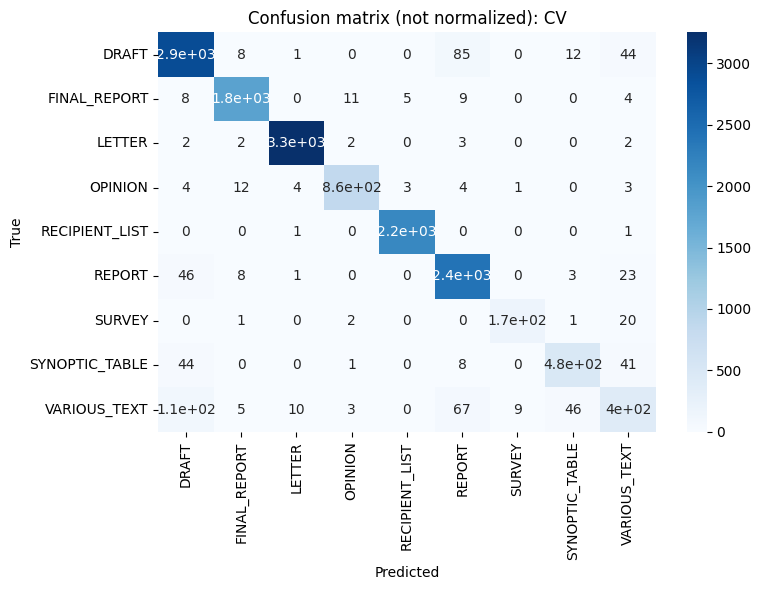

In [39]:
report = sklearn.metrics.classification_report(y_train, y_cv_predicted, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_train, y_cv_predicted, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

## Training

In [40]:
classifier_test = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=hyperparams,
    random_state=RANDOM_STATE,
)
classifier_test.fit(X_train, y_train)

2025/06/18 20:43:37 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/06/18 20:44:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


,steps,"[('columntransformer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluation on test_2

                precision    recall  f1-score   support

         DRAFT       0.87      0.92      0.90        51
  FINAL_REPORT       0.88      1.00      0.93        14
        LETTER       0.96      1.00      0.98        71
       OPINION       0.80      1.00      0.89         4
RECIPIENT_LIST       1.00      1.00      1.00        33
        REPORT       0.91      0.94      0.93        86
        SURVEY       1.00      1.00      1.00         9
SYNOPTIC_TABLE       0.90      0.90      0.90        41
  VARIOUS_TEXT       0.98      0.75      0.85        53

      accuracy                           0.93       362
     macro avg       0.92      0.95      0.93       362
  weighted avg       0.93      0.93      0.93       362



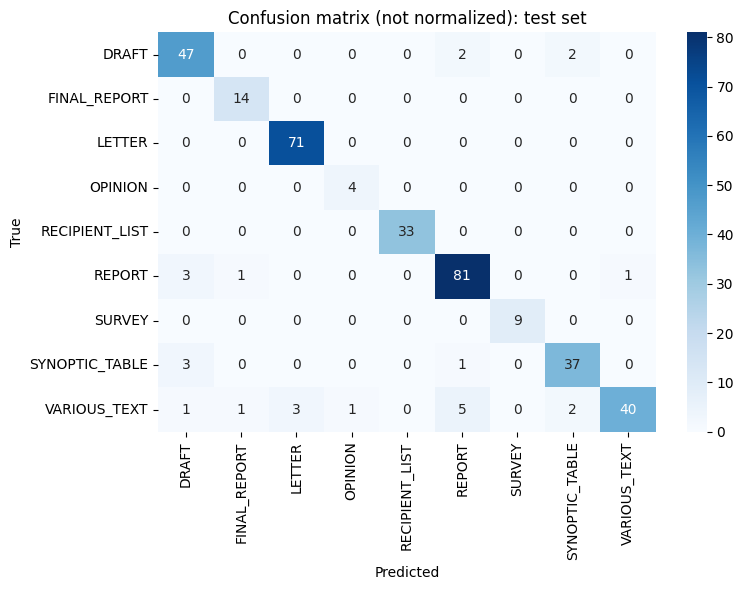

{'test_accuracy': 0.9282,
 'test_f1': 0.9269,
 'test_precision': 0.9308,
 'test_recall': 0.9282}


In [41]:
y_test_2_predicted = classifier_test.predict(X_test_2)

# Classification report
report = sklearn.metrics.classification_report(
    y_test_2,
    y_test_2_predicted,
    zero_division=np.nan,
)
mlflow.log_text(report, "test_classification_report.txt")
print(report)

# Confusion matrix
cm = plotting.plot_confusion_matrix_heatmap(y_test_2, y_test_2_predicted, title="test set")
mlflow.log_figure(cm, "test_confusion_matrix.png")
display(cm)

# Metrics
test_metrics = sklearn.metrics.precision_recall_fscore_support(
    y_test_2,
    y_test_2_predicted,
    average="weighted",
    zero_division=np.nan,
)
utils.log_metrics(
    test_precision=test_metrics[0],
    test_recall=test_metrics[1],
    test_f1=test_metrics[2],
    test_accuracy=sklearn.metrics.accuracy_score(y_test_2, y_test_2_predicted),
    # test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(y_test_2, classifier_test_2.predict_proba(X_test_2)),
)

### Feature importance

In [42]:
# forest = classifier_test.named_steps["randomforestclassifier"]
# pca = demokratis_ml.models.document_types.model.get_pca_step(classifier_test)
# assert pca is not None

# forest_importances = pd.Series(
#     forest.feature_importances_,
#     index=(
#         [f"embedding_{i:02d}" for i in range(pca.n_components)]
#         + list(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS)
#         + list(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
#     ),
# )
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# fig, ax = plt.subplots(figsize=(12, 2.5 * np.log(len(forest_importances))))
# forest_importances.plot.barh(xerr=std, ax=ax)
# ax.invert_yaxis()  # start with embeddings at the top
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

# mlflow.log_figure(fig, "feature_importance_mdi.png")

### Results per canton

In [43]:
df_eval = df_input_test_2.copy()
df_eval["document_type_predicted"] = y_test_2_predicted

for canton_code, df_canton in df_eval.groupby("political_body", observed=False):
    # Skip the "ch" political_body, which is the federal level and not a canton
    if canton_code == "ch":
        continue
    print(f"\n{'-' * 60}\n{canton_code}\n{'-' * 60}")
    if df_canton.empty:
        print("No data")
    else:
        report = sklearn.metrics.classification_report(
            df_canton["document_type"], df_canton["document_type_predicted"], zero_division=np.nan
        )
        print(report)


------------------------------------------------------------
ag
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       0.00       nan      0.00         0
        LETTER       1.00      1.00      1.00         5
RECIPIENT_LIST       1.00      1.00      1.00         6
        REPORT       1.00      1.00      1.00         8
        SURVEY       1.00      1.00      1.00         7
SYNOPTIC_TABLE       0.89      0.89      0.89         9
  VARIOUS_TEXT       1.00      0.83      0.91         6

      accuracy                           0.95        41
     macro avg       0.84      0.95      0.83        41
  weighted avg       0.98      0.95      0.96        41


------------------------------------------------------------
ai
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       1.00      1.00      1.00         8
        LETTER  

## Comparison to the rule-based model

In [44]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_input_test_2.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
y_test_predicted_rules = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df),
    demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.28% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.31% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.66% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.28% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
WARNING document_ti

                precision    recall  f1-score   support

         DRAFT       0.77      1.00      0.87        43
  FINAL_REPORT       1.00      0.33      0.50         3
        LETTER       0.97      1.00      0.99        66
RECIPIENT_LIST       1.00      1.00      1.00        27
        REPORT       0.96      0.88      0.92        76
        SURVEY       1.00      1.00      1.00         9
SYNOPTIC_TABLE       1.00      0.91      0.95        34
  VARIOUS_TEXT       1.00      0.83      0.90        23

      accuracy                           0.94       281
     macro avg       0.96      0.87      0.89       281
  weighted avg       0.95      0.94      0.94       281



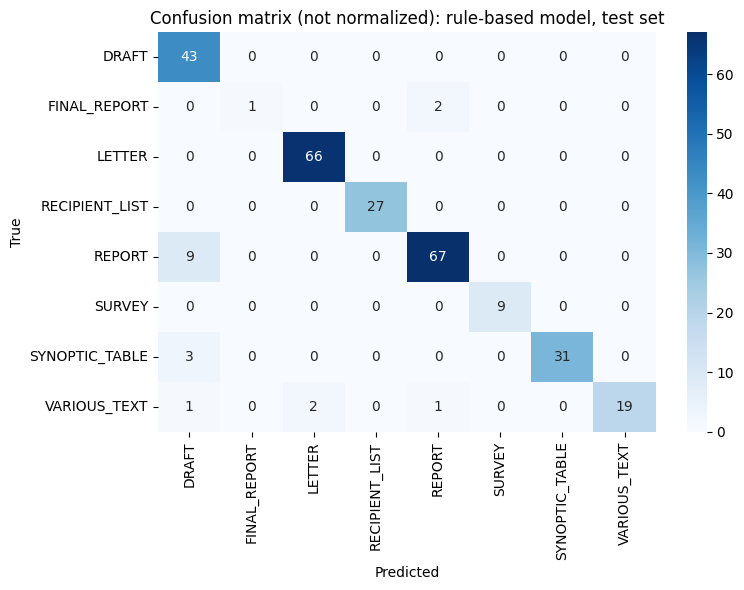

In [45]:
_y_true = y_test_2[y_test_predicted_rules.notna()]
_y_predicted = y_test_predicted_rules[y_test_predicted_rules.notna()]

print(sklearn.metrics.classification_report(_y_true, _y_predicted, zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _y_true,
    _y_predicted,
    title="rule-based model, test set",
    # normalize="true",
)

## Display all test samples & predictions

In [46]:
df_display = df_input_test_2.copy()
df_display["prediction_rule"] = y_test_predicted_rules
df_display["prediction_ml"] = y_test_2_predicted

df_display[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).apply(
    lambda row: [
        f"color: {'green' if row[col] == row['document_type'] else 'red'}"
        if col in {"prediction_rule", "prediction_ml"}
        else ""
        for col in row.index
    ],
    axis=1,
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
42506,43210,lu,vnl,doc,Erläuterungen,REPORT,REPORT,REPORT
47271,48271,zh,vnl,doc,Verordnungstext DeNaV,DRAFT,nan,DRAFT
53201,55141,zg,vnl,doc,Erlasstext Verordnung,DRAFT,DRAFT,DRAFT
42735,43441,lu,vnl,doc,Vernehmlassungsbotschaft,REPORT,REPORT,REPORT
45117,45863,tg,vnl,doc,RRB 392 Solidaritätsbeitrag,VARIOUS_TEXT,VARIOUS_TEXT,VARIOUS_TEXT
51928,53755,lu,vnl,doc,Gesetzesentwurf GaG,DRAFT,DRAFT,DRAFT
42677,43381,lu,vnl,doc,Erläuterungen,REPORT,REPORT,REPORT
53125,55063,ag,vnl,doc,Beilage zum Anhörungsbericht (Synopse),SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
51242,52976,sh,vnl,doc,Begleitschreiben Archivgesetz,LETTER,LETTER,LETTER
42681,43385,lu,vnl,doc,Erläuternder Bericht und Vernehmlassungsvorlage,REPORT,REPORT,REPORT


***

# End run

In [47]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [48]:
mlflow.end_run()

🏃 View run glamorous-wolf-48 at: https://mlflow.ml1.demokratis.ch/#/experiments/4/runs/80269022590f4aa1a3524914fb4e6d51
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/4
